Import packages and navigate to model data directory

In [1]:
# Import packages
import os
import emc2
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from datetime import datetime, timedelta
from emc2.core.instruments import HSRL
from emc2.core.instruments import WACR
from emc2.core import Instrument
from emc2.core.instrument import ureg
from emc2.core import Model

# Navigate to the UM_reg data directory
os.chdir('/g/data3/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2')
# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2


# Set up model and instrument classes

Create the UM regional model class

In [2]:
class UM(Model):
    def __init__(self, file_path, time_range=None, load_processed=False, time_dim="time", appended_str=False, all_appended_in_lat=False):#, calc_re = True):
        """
        This loads a UM simulation with all of the necessary parameters for EMC2 to run.
        Parameters
        ----------
        file_path: str
            Path to a UM simulation.
        time_range: tuple, list, or array, typically in datetime64 format
            Two-element array with starting and ending of time range.
        load_processed: bool
            If True, treating the 'file_path' variable as an EMC2-processed dataset; thus skipping
            appended string removal and dimension stacking, which are typically part of pre-processing.
        time_dim: str
            Name of the time dimension. Typically "time" or "ncol".
        appended_str: bool
            If True, removing appended strings added to fieldnames and coordinates during
            post-processing (e.g., in cropped regions from global simualtions).
        all_appended_in_lat: bool
            If True using only the appended str portion to the lat_dim. Otherwise, combining
            the appended str from both the lat and lon dims (relevant if appended_str is True).
        """
        super().__init__()
        self.Rho_hyd = {'cl': 1000. * ureg.kg / (ureg.m**3),
                        'ci': 500. * ureg.kg / (ureg.m**3),
                        'pl': 1000. * ureg.kg / (ureg.m**3),
                        'pi': 250. * ureg.kg / (ureg.m**3),
                        'gr': 500. * ureg.kg / (ureg.m**3)}
        # Graupel densities can range from 0.2 to about 0.8 g/cm^3, so I'm choosing 0.5 g/cm^3, or 500 k/gm^3
        # 50 to 890 kg/m^3 (Pruppacher and Klett, 1978)
        self.fluffy = {'ci': 0.5 * ureg.dimensionless,
                       'pi': 0.5 * ureg.dimensionless,
                       'gr': 0.5 * ureg.dimensionless}
        # Possible fluffiness parameter apparently from Field et al. (2023), Table A1, is 0.422; however, for now I will leave this the same as for the other ice species
        self.lidar_ratio = {'cl': 18. * ureg.dimensionless,
                            'ci': 24. * ureg.dimensionless,
                            'pl': 5.5 * ureg.dimensionless,
                            'pi': 24. * ureg.dimensionless,
                            'gr': 24. * ureg.dimensionless}
        # Graupel lidar ratio assumed to be the same as for other ice species
        self.LDR_per_hyd = {'cl': 0.03 * 1 / (ureg.kg / (ureg.m**3)),
                            'ci': 0.35 * 1 / (ureg.kg / (ureg.m**3)),
                            'pl': 0.10 * 1 / (ureg.kg / (ureg.m**3)),
                            'pi': 0.40 * 1 / (ureg.kg / (ureg.m**3)),
                            'gr': 0.40 * 1 / (ureg.kg / (ureg.m**3))}
        # LDR per hydrometeor assumed to be the same as for precipitating ice
        self.vel_param_a = {'cl': 3e-7,
                            'ci': 700.,
                            'pl': 841.997,
                            'pi': 11.72,
                            'gr': 253.}
        # Fall velocity parameter a from Field et al. (2023), Table A1
        self.vel_param_b = {'cl': 2. * ureg.dimensionless,
                            'ci': 1. * ureg.dimensionless,
                            'pl': 0.8 * ureg.dimensionless,
                            'pi': 0.41 * ureg.dimensionless,
                            'gr': 0.734 * ureg.dimensionless}
        # Fall velocity parameter b from Field et al. (2023), Table A1
        super()._add_vel_units()
        # Names of mixing ratio of species
        self.q_names = {'cl': 'mass_fraction_of_cloud_liquid_water_in_air', 'ci': 'mass_fraction_of_cloud_ice_crystals_in_air', 'pl': 'mass_fraction_of_rain_in_air', 'pi': 'mass_fraction_of_cloud_ice_in_air', 'gr': 'mass_fraction_of_graupel_in_air'}
        # Number concentration of each species
        self.N_field = {'cl': 'number_of_cloud_droplets_per_kg_of_air', 'ci': 'number_of_ice_particles_per_kg_of_air', 'pl': 'number_of_rain_drops_per_kg_of_air', 'pi': 'number_of_snow_aggregates_per_kg_of_air', 'gr': 'number_of_graupel_particles_per_kg_of_air'}
        # Stratiform fraction
        # Hydrometeor fractions are one of the most essential variables for the simulator.
        # Based on the information you provided (only a single relevant fraction field), fractions are likely “generalized” (identical for all hydrometeor types – commonly used in models – makes life easier, especially in radiative transfer calculations).
        # In EMC2 they are essential because they inform us about the “in-cloud” or more generally, “in-hydrometeor field values” by dividing the number and mass by it.
        # If that is indeed the case (and I recommend verifying that this is the case with a UM expert), then you should assign it to all classes in both strat_frac_names_for_rad (used by radiation approach) and strat_frac_names (used by microphysics approach).
        self.strat_frac_names = {'cl': 'cloud_area_fraction_in_atmosphere_layer', 'ci': 'cloud_area_fraction_in_atmosphere_layer', 'pl': 'cloud_area_fraction_in_atmosphere_layer', 'pi': 'cloud_area_fraction_in_atmosphere_layer', 'gr': 'cloud_area_fraction_in_atmosphere_layer'}
        self.strat_frac_names_for_rad = {'cl': 'cloud_area_fraction_in_atmosphere_layer', 'ci': 'cloud_area_fraction_in_atmosphere_layer', 'pl': 'cloud_area_fraction_in_atmosphere_layer', 'pi': 'cloud_area_fraction_in_atmosphere_layer', 'gr': 'cloud_area_fraction_in_atmosphere_layer'}
        # Convective fraction
        self.conv_frac_names = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        self.conv_frac_names_for_rad = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        
        # # Effective radius
        # # self.re_fields = {'cl': 'cloud_liquid_effective_radius', 'ci': 'cloud_ice_effective_radius', 'pl': 'precip_liquid_effective_radius', 'pi': 'precip_ice_effective_radius', 'gr': 'precip_graupel_effective_radius'}
        # self.strat_re_fields = {'cl': 'cloud_liquid_effective_radius', 'ci': 'cloud_ice_effective_radius', 'pl': 'precip_liquid_effective_radius', 'pi': 'precip_ice_effective_radius', 'gr': 'precip_graupel_effective_radius'}
        # self.conv_re_fields = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}

        # Not currently in use
        # Assume strat_re_fields is a dictionary mapping hydrometeor classes to effective radius fields
        # The effective radius fields here are left empty for use where calc_re = True
        self.strat_re_fields = {
            'cl': 'effective_radius_cl',
            'ci': 'effective_radius_ci',
            'pl': 'effective_radius_pl',
            'pi': 'effective_radius_pi',
            'gr': 'effective_radius_gr'
        }
        
        # Stratiform mixing ratio
        self.q_names_stratiform = {'cl': 'mass_fraction_of_cloud_liquid_water_in_air', 'ci': 'mass_fraction_of_cloud_ice_crystals_in_air', 'pl': 'mass_fraction_of_rain_in_air', 'pi': 'mass_fraction_of_cloud_ice_in_air', 'gr': 'mass_fraction_of_graupel_in_air'}
        # Convective mixing ratio
        self.q_names_convective = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var', 'gr': 'zeros_var'}
        # Water vapor mixing ratio
        self.q_field = "zeros_var"
        # Pressure
        self.p_field = "air_pressure"
        # Height
        self.z_field = "height_var"
        # Temperature
        self.T_field = "air_temperature"
        # Name of height dimension
        self.height_dim = "level_height"
        # Name of time dimension
        self.time_dim = "time"
        self.hyd_types = ["cl", "ci", "pl", "pi", "gr"]
        self.process_conv = False

        # Load processed or unprocessed data
        if load_processed:
            self.ds = xr.Dataset()
            self.load_subcolumns_from_netcdf(file_path)
        else:
            self.ds = xr.open_dataset(file_path)
            if appended_str:
                if np.logical_and(not np.any(['ncol' in x for x in self.ds.coords]), all_appended_in_lat):
                    for x in self.ds.dims:
                        if 'ncol' in x:  # ncol in dims but for some reason not in the coords
                            self.ds = self.ds.assign_coords({'ncol': self.ds[x]})
                            self.ds = self.ds.swap_dims({x: "ncol"})
                            break
                super().remove_appended_str(all_appended_in_lat)
                if all_appended_in_lat:
                    self.lat_dim = "ncol"  # here 'ncol' is the spatial dim (acknowledging cube-sphere coords)

            # Add additional time coordinates
            if time_dim == "ncol":
                time_datetime64 = np.array([x.strftime('%Y-%m-%dT%H:%M') for x in self.ds["time"].values],
                                           dtype='datetime64')
                self.ds = self.ds.assign_coords(time=('ncol', time_datetime64))

            # Crop specific model output time range (if requested)
            if time_range is not None:
                if np.issubdtype(time_range.dtype, np.datetime64):
                    if time_dim == "ncol":
                        super()._crop_time_range(time_range, alter_coord="time")
                    else:
                        super()._crop_time_range(time_range)
                else:
                    raise RuntimeError("Input time range is not in the required datetime64 data type")
                    
            # Stack dimensions in the case of a regional output or squeeze lat/lon dims if exist and len==1
            super().check_and_stack_time_lat_lon(file_path=file_path, order_dim=False)
            
            # Convert pressure units from Pa to hPa
            if self.ds[self.p_field].units == "pascal":
                # Convert pressure field from Pa to hPa
                self.ds[self.p_field] = self.ds[self.p_field] / 100.0
                self.ds[self.p_field].attrs["units"] = "hPa"
            
            # # Convert effective radii from meters to microns
            # for hyd in ['cl', 'ci', "pl", "pi", 'gr']:
            #     if self.ds[self.strat_re_fields[hyd]].units == 'meter':
            #         self.ds[self.strat_re_fields[hyd]].values *= 1e6
            #         self.ds[self.strat_re_fields[hyd]].attrs["units"] = "micron"
                    
            # Calculate air density
            self.ds["rho_a"] = self.ds[self.p_field] * 1e2 / (self.consts["R_d"] * self.ds[self.T_field])
            self.ds["rho_a"].attrs["units"] = "kg / m ** 3"

            # Convert number concentration from 1/kg to 1/cm^3
            for hyd in ["cl", "ci", "pl", "pi", 'gr']:
                if self.ds[self.N_field[hyd]].units == '1 / kilogram':
                    self.ds[self.N_field[hyd]].values *= self.ds["rho_a"].values / 1e6
                    self.ds[self.N_field[hyd]].attrs["units"] = "1 / cm^3"
                    # self.ds[self.strat_re_fields[hyd]].values = \
                    #     np.where(self.ds[self.strat_re_fields[hyd]].values == 0.,
                    #              np.nan, self.ds[self.strat_re_fields[hyd]].values)
            
            # Ensure consistent dimension order (time x height)
            self.permute_dims_for_processing()
            
        # Name the model
        self.model_name = "UM_reg"

Create the MPL instrument class instance

In [3]:
MPL = HSRL()

Create the MWACR instrument class instance

In [4]:
MWACR = WACR(site = 'micre')

Create the UM_reg model class instance for each day and create the simulated data

# Multiple file saving

In [5]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'um_reg_marcus_' in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180207.nc']

In [7]:
# Output path
output_folder = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/emc2_output'

# SINGLE FILE TEST
# daily_UM_reg_list = [daily_UM_reg_list[0]]

# Loop across all files in daily_UM_reg_list, run the EMC2 simulator for each, and save the .ds output
for file in daily_UM_reg_list:
    
    # Get the string for the current date
    current_date_str = file.split('_')[-1].split('.')[0]

    # Create the required instances of the UM_reg model class
    UM_reg_instance_lidar_radiation = UM(file)
    UM_reg_instance_radar_radiation = UM(file)
    UM_reg_instance_lidar_microphysics = UM(file)
    UM_reg_instance_radar_microphysics = UM(file)

    # Radiation logic
    # Create simulated lidar data
    UM_reg_emc2_marcus_MPL_radiation_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_lidar_radiation, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = True, parallel = False, calc_re = True)
    print('Successfully completed lidar instrument simulation using radiation logic')
    print('\n')
    # Create simulated radar data
    UM_reg_emc2_marcus_MWACR_radiation_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_radar_radiation, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = True, parallel = False, calc_re = True)
    print('Successfully completed radar instrument simulation using radiation logic')
    print('\n')
    # Microphysics logic
    # Create simulated lidar data
    UM_reg_emc2_marcus_MPL_microphysics_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_lidar_microphysics, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False, calc_re = True)
    print('Successfully completed lidar instrument simulation using microphysics logic')
    print('\n')
    # Create simulated radar data
    UM_reg_emc2_marcus_MWACR_microphysics_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_radar_microphysics, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False, calc_re = True)
    print('Successfully completed radar instrument simulation using microphysics logic')
    print('\n')
    
    # Save the simulated data for MPL and MWACR, radiation and microphysics logic
    # Radiation
    UM_reg_emc2_marcus_MPL_radiation_model_data = UM_reg_emc2_marcus_MPL_radiation_model.ds
    UM_reg_emc2_marcus_MWACR_radiation_model_data = UM_reg_emc2_marcus_MWACR_radiation_model.ds
    file_path_output_MPL_radiation = f'{output_folder}/um_reg_emc2_marcus_MPL_radiation_{current_date_str}.nc'
    file_path_output_MWACR_radiation = f'{output_folder}/um_reg_emc2_marcus_MWACR_radiation_{current_date_str}.nc'
    UM_reg_emc2_marcus_MPL_radiation_model_data.to_netcdf(file_path_output_MPL_radiation)
    UM_reg_emc2_marcus_MWACR_radiation_model_data.to_netcdf(file_path_output_MWACR_radiation)
    # Microphysics
    UM_reg_emc2_marcus_MPL_microphysics_model_data = UM_reg_emc2_marcus_MPL_microphysics_model.ds
    UM_reg_emc2_marcus_MWACR_microphysics_model_data = UM_reg_emc2_marcus_MWACR_microphysics_model.ds
    file_path_output_MPL_microphysics = f'{output_folder}/um_reg_emc2_marcus_MPL_microphysics_{current_date_str}.nc'
    file_path_output_MWACR_microphysics = f'{output_folder}/um_reg_emc2_marcus_MWACR_microphysics_{current_date_str}.nc'
    UM_reg_emc2_marcus_MPL_microphysics_model_data.to_netcdf(file_path_output_MPL_microphysics)
    UM_reg_emc2_marcus_MWACR_microphysics_model_data.to_netcdf(file_path_output_MWACR_microphysics)

print('Finished creating and saving simulated instrument data')

## Creating subcolumns...
No convective processing for UM_reg
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

# Saved file checks and plotting

In [5]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'um_reg_marcus_' in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180207.nc']

In [30]:
# Set the test file
file = daily_UM_reg_list[3]
print(file)
# Set the model class instances
UM_reg_instance_lidar_radiation = UM(file)
UM_reg_instance_radar_radiation = UM(file)
UM_reg_instance_lidar_microphysics = UM(file)
UM_reg_instance_radar_microphysics = UM(file)
# Examine the selected test file
test = UM_reg_instance_lidar_radiation.ds
test

/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc


<xarray.Dataset>
Dimensions:                                     (model_level_number: 90,
                                                 time: 144, level_height: 90)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] ...
    level_height                                (model_level_number) float64 ...
    sigma                                       (model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
Data variables: (12/21)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    number_of_ice_particles_per_kg_of_air       (time, model_level_number) float64 ...
    number_of_rain_drops_per_kg_of_air          (time, model_level_number) float64 ...
    number_of_snow_aggregates_per_kg_of_air     (time, model_level_number) float64 ...
    number_of_graupel_particles_per_kg_of_air   (time, model_level_number) float64 ...
    specific_humidity                           (time, model_level_number) float64 ...
    rho_a                                       (time, model_level_number) float64 ...
Attributes:
    description:    UM regional model data subsetted to the MARCUS RSV location
    authors:        Calum L. Knight & Sonya L. Fiddes
    creation_date:  2024-03-26

In [31]:
# Check maximum values and assigned units
print('Field maximum values')
print('\n')
print('Mass mixing ratio')
print('Cloud liquid:', np.max(test['mass_fraction_of_cloud_liquid_water_in_air'].values), test['mass_fraction_of_cloud_liquid_water_in_air'].attrs)
print('Cloud ice:', np.max(test['mass_fraction_of_cloud_ice_crystals_in_air'].values), test['mass_fraction_of_cloud_ice_crystals_in_air'].attrs)
print('Precip liquid:', np.max(test['mass_fraction_of_rain_in_air'].values), test['mass_fraction_of_rain_in_air'].attrs)
print('Precip ice:', np.max(test['mass_fraction_of_cloud_ice_in_air'].values),test['mass_fraction_of_cloud_ice_in_air'].attrs)
print('Precip graupel:', np.max(test['mass_fraction_of_graupel_in_air'].values),test['mass_fraction_of_graupel_in_air'].attrs)
print('\n')
print('Number concentration')
print('Cloud liquid:', np.max(test['number_of_cloud_droplets_per_kg_of_air'].values), test['number_of_cloud_droplets_per_kg_of_air'].attrs)
print('Cloud ice:', np.max(test['number_of_ice_particles_per_kg_of_air'].values), test['number_of_ice_particles_per_kg_of_air'].attrs)
print('Precip liquid:', np.max(test['number_of_rain_drops_per_kg_of_air'].values), test['number_of_rain_drops_per_kg_of_air'].attrs)
print('Precip ice:', np.max(test['number_of_snow_aggregates_per_kg_of_air'].values), test['number_of_snow_aggregates_per_kg_of_air'].attrs)
print('Precip graupel:', np.max(test['number_of_graupel_particles_per_kg_of_air'].values), test['number_of_graupel_particles_per_kg_of_air'].attrs)
print('\n')
print('Stratiform fraction')
print('Cloud liquid:', np.max(test['cloud_area_fraction_in_atmosphere_layer'].values), test['cloud_area_fraction_in_atmosphere_layer'].attrs)
print('\n')

print('Other')
print('Water vapour mixing ratio (specific humidity):', np.max(test['specific_humidity'].values), test['specific_humidity'].attrs)
print('Pressure:', np.max(test['air_pressure'].values), test['air_pressure'].attrs)
print('Temperature:', np.max(test['air_temperature'].values), test['air_temperature'].attrs)
print('Air density:', np.max(test['rho_a'].values), test['rho_a'].attrs)
print('Height:', np.max(test['height_var'].values), test['height_var'].attrs)

Field maximum values


Mass mixing ratio
Cloud liquid: 0.000320389003277939 {'units': 'dimensionless'}
Cloud ice: 2.550978056567804e-05 {'units': 'dimensionless'}
Precip liquid: 4.479424855007592e-07 {'units': 'dimensionless'}
Precip ice: 0.00024499852459940614 {'units': 'dimensionless'}
Precip graupel: 1.2712241415670322e-07 {'units': 'dimensionless'}


Number concentration
Cloud liquid: 146.72663835142112 {'units': '1 / cm^3'}
Cloud ice: 0.6268094868391314 {'units': '1 / cm^3'}
Precip liquid: 0.003147967119205405 {'units': '1 / cm^3'}
Precip ice: 0.11091914719885325 {'units': '1 / cm^3'}
Precip graupel: 0.0001047208795674982 {'units': '1 / cm^3'}


Stratiform fraction
Cloud liquid: 1.0 {'units': 'dimensionless'}


Other
Water vapour mixing ratio (specific humidity): 0.002862013772675097 {'units': 'dimensionless'}
Pressure: 1005.304600178157 {'units': 'hPa'}
Temperature: 271.5272369010044 {'units': 'kelvin'}
Air density: 1.3055324385733098 {'units': 'kg / m ** 3'}
Height: 40000.0 {'un

Create simulated data using radiation logic

In [32]:
# Create simulated lidar data
UM_reg_emc2_marcus_MPL_radiation_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_lidar_radiation, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = True, parallel = False, calc_re = True)
print('Successfully completed lidar instrument simulation using radiation logic')
# Create simulated radar data
print('\n')
UM_reg_emc2_marcus_MWACR_radiation_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_radar_radiation, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = True, parallel = False, calc_re = True)
print('Successfully completed radar instrument simulation using radiation logic')

## Creating subcolumns...
No convective processing for UM_reg
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.02s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.08s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

Create simulated data using microphysics logic

In [33]:
# Create simulated lidar data
UM_reg_emc2_marcus_MPL_microphysics_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_lidar_microphysics, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False, calc_re = True)
print('Successfully completed lidar instrument simulation using microphysics logic')
# Create simulated radar data
print('\n')
UM_reg_emc2_marcus_MWACR_microphysics_model = emc2.simulator.main.make_simulated_data(UM_reg_instance_radar_microphysics, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False, calc_re = True)
print('Successfully completed radar instrument simulation using microphysics logic')

## Creating subcolumns...
No convective processing for UM_reg
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

In [37]:
# Examine a sample of the simulated data
emc2_output_test_MPL = UM_reg_emc2_marcus_MPL_radiation_model.ds
emc2_output_test_MWACR = UM_reg_emc2_marcus_MWACR_radiation_model.ds

# Examine effective radii computed by EMC2 (Thompson et al., 2004)
print('Cloud liquid:', np.max(xr.where(np.isinf(emc2_output_test_MPL['effective_radius_cl'].fillna(0)), 0, emc2_output_test_MPL['effective_radius_cl'].fillna(0)).values), emc2_output_test_MPL['effective_radius_cl'].attrs)
print('Cloud ice:', np.max(xr.where(np.isinf(emc2_output_test_MPL['effective_radius_ci'].fillna(0)), 0, emc2_output_test_MPL['effective_radius_ci'].fillna(0)).values), emc2_output_test_MPL['effective_radius_ci'].attrs)
print('Precip liquid:', np.max(xr.where(np.isinf(emc2_output_test_MPL['effective_radius_pl'].fillna(0)), 0, emc2_output_test_MPL['effective_radius_pl'].fillna(0)).values), emc2_output_test_MPL['effective_radius_pl'].attrs)
print('Precip ice:', np.max(xr.where(np.isinf(emc2_output_test_MPL['effective_radius_pi'].fillna(0)), 0, emc2_output_test_MPL['effective_radius_pi'].fillna(0)).values), emc2_output_test_MPL['effective_radius_pi'].attrs)
print('Precip graupel:', np.max(xr.where(np.isinf(emc2_output_test_MPL['effective_radius_gr'].fillna(0)), 0, emc2_output_test_MPL['effective_radius_gr'].fillna(0)).values), emc2_output_test_MPL['effective_radius_gr'].attrs)

# Reset the test dataset for comparison
test = xr.open_dataset(file)
test

Cloud liquid: 8.594590849570098 {'units': 'microns', 'long_name': 'Particle effective radius following Thompson et al. (2004)'}
Cloud ice: 6618.689083404778 {'units': 'microns', 'long_name': 'Particle effective radius following Thompson et al. (2004)'}
Precip liquid: 139.2289996899532 {'units': 'microns', 'long_name': 'Particle effective radius following Thompson et al. (2004)'}
Precip ice: 1270.938301628416 {'units': 'microns', 'long_name': 'Particle effective radius following Thompson et al. (2004)'}
Precip graupel: 2434.385694173134 {'units': 'microns', 'long_name': 'Particle effective radius following Thompson et al. (2004)'}


<xarray.Dataset>
Dimensions:                                     (model_level_number: 90,
                                                 time: 144, level_height: 90)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] ...
    level_height                                (model_level_number) float64 ...
    sigma                                       (model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
Data variables: (12/20)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    number_of_cloud_droplets_per_kg_of_air      (time, model_level_number) float64 ...
    number_of_ice_particles_per_kg_of_air       (time, model_level_number) float64 ...
    number_of_rain_drops_per_kg_of_air          (time, model_level_number) float64 ...
    number_of_snow_aggregates_per_kg_of_air     (time, model_level_number) float64 ...
    number_of_graupel_particles_per_kg_of_air   (time, model_level_number) float64 ...
    specific_humidity                           (time, model_level_number) float64 ...
Attributes:
    description:    UM regional model data subsetted to the MARCUS RSV location
    authors:        Calum L. Knight & Sonya L. Fiddes
    creation_date:  2024-03-26

In [38]:
emc2_output_test_MPL

<xarray.Dataset>
Dimensions:                                     (model_level_number: 90,
                                                 time: 144, level_height: 90,
                                                 subcolumn: 1)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] 2018-02-03T12:...
    level_height                                (model_level_number) float64 ...
    sigma                                       (time, model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
  * subcolumn                                   (subcolumn) int64 0
Data variables: (12/78)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    sub_col_LDR_strat                           (subcolumn, time, model_level_number) float64 ...
    sub_col_LDR_tot                             (subcolumn, time, model_level_number) float64 ...
    ext_mask                                    (subcolumn, time, model_level_number) float64 ...
    phase_mask_HSRL_all_hyd                     (subcolumn, time, model_level_number) float64 ...
    strat_COSP_phase_mask                       (subcolumn, time, model_level_number) float64 ...
    COSP_phase_mask_all_hyd                     (subcolumn, time, model_level_number) float64 ...
Attributes:
    description:    UM regional model data subsetted to the MARCUS RSV location
    authors:        Calum L. Knight & Sonya L. Fiddes
    creation_date:  2024-03-26

In [39]:
emc2_output_test_MWACR

<xarray.Dataset>
Dimensions:                                     (model_level_number: 90,
                                                 time: 144, level_height: 90,
                                                 subcolumn: 1)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] 2018-02-03T12:...
    level_height                                (model_level_number) float64 ...
    sigma                                       (model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
  * subcolumn                                   (subcolumn) int64 0
Data variables: (12/58)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    sub_col_Ze_att_tot_strat                    (subcolumn, time, model_level_number) float64 ...
    Ze_min                                      (time, level_height) float64 ...
    sub_col_Ze_tot                              (subcolumn, time, model_level_number) float64 ...
    sub_col_Ze_att_tot                          (subcolumn, time, model_level_number) float64 ...
    detect_mask                                 (time, level_height, subcolumn, model_level_number) bool ...
    phase_mask_WACR_sounding_all_hyd            (subcolumn, time, model_level_number) float64 ...
Attributes:
    description:    UM regional model data subsetted to the MARCUS RSV location
    authors:        Calum L. Knight & Sonya L. Fiddes
    creation_date:  2024-03-26

In [42]:
# Check which variables are in 'emc2_output_test_MPL' but not in 'test' and print the attributes of those variables
for var_name in emc2_output_test_MPL.variables:
    if var_name not in test.variables:
        var = emc2_output_test_MPL[var_name]
        print(f"Variable Name: {var_name}")
        print(f"Attributes: {var.attrs}")
        print("---------------------")

Variable Name: rho_a
Attributes: {'units': 'kg / m ** 3'}
---------------------
Variable Name: subcolumn
Attributes: {}
---------------------
Variable Name: strat_frac_subcolumns_cl
Attributes: {'long_name': 'Liquid cloud particles present? [stratiform]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_ci
Attributes: {'long_name': 'Liquid cloud particles present? [stratiform]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_pl
Attributes: {'long_name': 'Liquid precipitation present? [pl]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_pi
Attributes: {'long_name': 'Ice precipitation present? [pi]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_gr
Attributes: {'long_name':

In [43]:
# Check which variables are in 'emc2_output_test_MWACR' but not in 'test' and print the attributes of those variables
for var_name in emc2_output_test_MWACR.variables:
    if var_name not in test.variables:
        var = emc2_output_test_MWACR[var_name]
        print(f"Variable Name: {var_name}")
        print(f"Attributes: {var.attrs}")
        print("---------------------")

Variable Name: rho_a
Attributes: {'units': 'kg / m ** 3'}
---------------------
Variable Name: subcolumn
Attributes: {}
---------------------
Variable Name: strat_frac_subcolumns_cl
Attributes: {'long_name': 'Liquid cloud particles present? [stratiform]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_ci
Attributes: {'long_name': 'Liquid cloud particles present? [stratiform]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_pl
Attributes: {'long_name': 'Liquid precipitation present? [pl]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_pi
Attributes: {'long_name': 'Ice precipitation present? [pi]', 'units': '0 = no, 1 = yes', 'Processing method': 'Radiation logic'}
---------------------
Variable Name: strat_frac_subcolumns_gr
Attributes: {'long_name':

Radiation logic plots

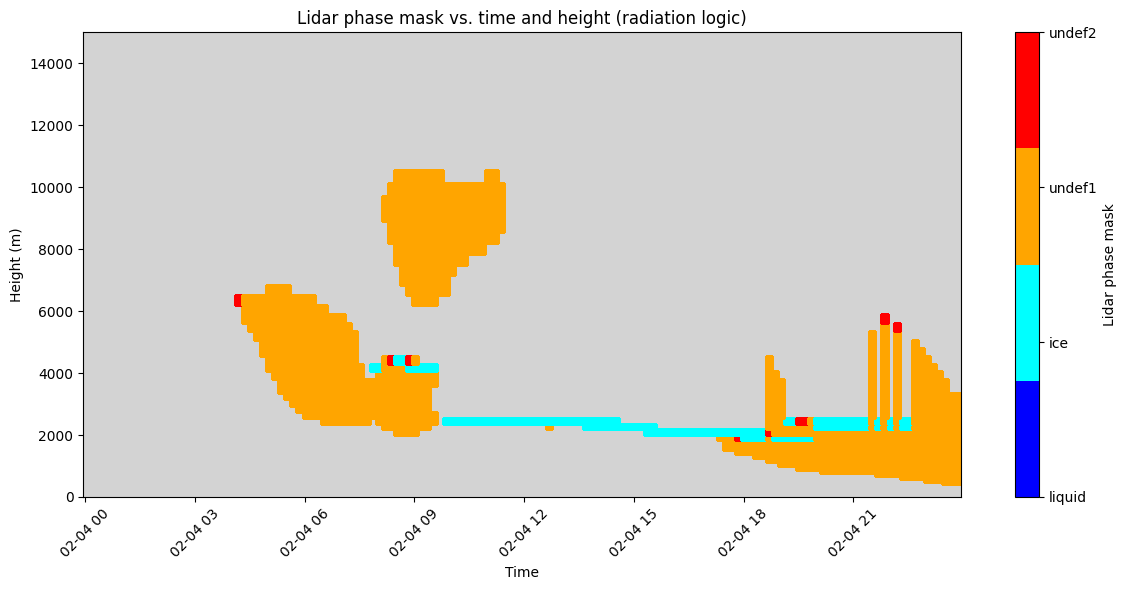

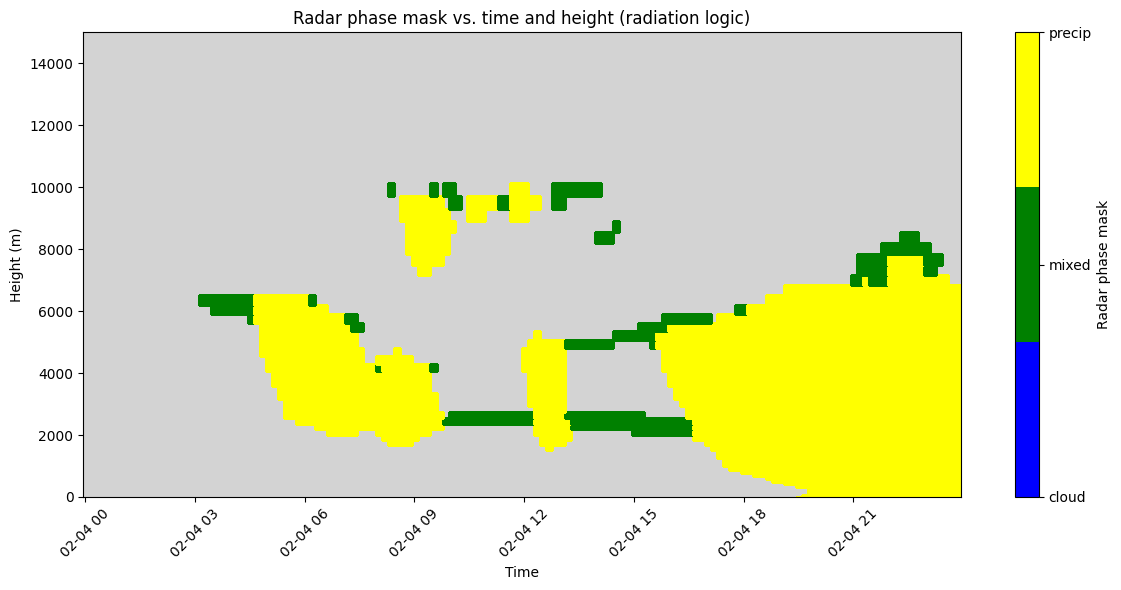

In [54]:
# Set the height limit for the plots
ylim_max = 15000

# # Backscatter
# # Create a meshgrid for time and height to be used for all lidar plots produced from the current file
# time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MPL_radiation_model.ds['time'], UM_reg_emc2_marcus_MPL_radiation_model.ds['level_height'])
# # Extract the desired variable
# backscatter = UM_reg_emc2_marcus_MPL_radiation_model.ds['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# # backscatter = UM_reg_emc2_marcus_MPL_radiation_model.ds['sub_col_beta_att_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm=LogNorm(vmin=1e-9, vmax=2e-2))
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
# plt.title('Backscatter vs. time and height (radiation logic)')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# # Mask areas where ext_mask != 2
# ext_mask = UM_reg_emc2_marcus_MPL_radiation_model.ds['ext_mask'].isel(subcolumn=0).drop('subcolumn')
# masked_ext_mask = np.where(ext_mask == 2, ext_mask, np.nan)
# # Overplot areas where ext_mask == 2 with black hatching
# # plt.pcolor(time_mesh, height_mesh, masked_ext_mask.T, hatch='/////', alpha=0.)
# UM_reg_emc2_output_backscatter = plt.gcf()
# # Save the plot
# UM_reg_emc2_output_backscatter.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_backscatter_radiation', dpi = 200)

# # Depol
# # Extract the desired variable
# depol = UM_reg_emc2_marcus_MPL_radiation_model.ds['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'viridis', shading = 'auto', vmin=0, vmax=1)
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'LDR')
# plt.title('Linear depolarization ratio vs. time and height (radiation logic)')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# # Overplot areas where ext_mask == 2 with black hatching
# # plt.pcolor(time_mesh, height_mesh, masked_ext_mask.T, hatch='/////', alpha=0.)
# UM_reg_emc2_output_depol = plt.gcf()
# # Save the plot
# UM_reg_emc2_output_depol.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_depol_radiation', dpi = 200)

# CLoud phase - lidar
# Extract the desired variable
lidar_phase = UM_reg_emc2_marcus_MPL_radiation_model.ds['phase_mask_HSRL_all_hyd'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Define the discrete colormap
colors = ['blue', 'cyan', 'orange', 'red'] 
cmap = mpl.colors.ListedColormap(colors)
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, lidar_phase.T, cmap=cmap, shading='auto', vmin=0, vmax=len(colors)-1)
pcm.set_edgecolor('face')
plt.xlabel('Time')
plt.ylabel('Height (m)')
cbar = plt.colorbar(pcm, ticks=np.arange(len(colors)), label='Lidar phase mask')
cbar.set_ticklabels(['liquid', 'ice', 'undef1', 'undef2'])
plt.title('Lidar phase mask vs. time and height (radiation logic)')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# Overplot areas where ext_mask == 2 with black hatching
# plt.pcolor(time_mesh, height_mesh, masked_ext_mask.T, hatch='/////', alpha=0.)
UM_reg_emc2_output_lidar_phase_mask = plt.gcf()
# Save the plot
UM_reg_emc2_output_lidar_phase_mask.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_lidar_phase_mask_radiation', dpi = 200)

# Reflectivity
# Create a meshgrid for time and height to be used for all radar plots produced from the current file
time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MWACR_radiation_model.ds['time'], UM_reg_emc2_marcus_MWACR_radiation_model.ds['level_height'])
# # Extract the desired variable
# reflectivity = UM_reg_emc2_marcus_MWACR_radiation_model.ds['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# # reflectivity = UM_reg_emc2_marcus_MWACR_radiation_model.ds['sub_col_Ze_att_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# # reflectivity = UM_reg_emc2_marcus_MWACR_radiation_model.ds['sub_col_Ze_att_tot'].isel(subcolumn=0).drop('subcolumn')
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto', vmin=-70, vmax=10)
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
# plt.title('Reflectivity vs. time and height (radiation logic)')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# # # Mask areas where ext_mask != 1
# # # detect_mask = UM_reg_emc2_marcus_MWACR_radiation_model.ds['detect_mask'].isel(subcolumn=0).drop('subcolumn')
# # detect_mask = UM_reg_emc2_marcus_MWACR_radiation_model.ds['detect_mask'].isel(subcolumn=0).drop('subcolumn').isel(level_height=0).drop('level_height')
# # masked_detect_mask = np.where(detect_mask == 1, detect_mask, np.nan)
# # # Overplot areas where ext_mask == 1 with black hatching
# # plt.pcolor(time_mesh, height_mesh, masked_detect_mask.T, hatch='/////', alpha=0.)
# UM_reg_emc2_output_reflectivity = plt.gcf()
# # Save the plot
# UM_reg_emc2_output_reflectivity.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_reflectivity_radiation', dpi = 200)

# Reflectivity
# Create a meshgrid for time and height to be used for all radar plots produced from the current file
time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MWACR_radiation_model.ds['time'], UM_reg_emc2_marcus_MWACR_radiation_model.ds['level_height'])
# Extract the desired variable
radar_phase = UM_reg_emc2_marcus_MWACR_radiation_model.ds['phase_mask_WACR_sounding_all_hyd'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Define the discrete colormap
colors = ['blue', 'green', 'yellow'] 
cmap = mpl.colors.ListedColormap(colors)
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, radar_phase.T, cmap=cmap, shading='auto', vmin=0, vmax=len(colors)-1)
pcm.set_edgecolor('face')
plt.xlabel('Time')
plt.ylabel('Height (m)')
cbar = plt.colorbar(pcm, ticks=np.arange(len(colors)), label='Radar phase mask')
cbar.set_ticklabels(['cloud', 'mixed', 'precip'])
plt.title('Radar phase mask vs. time and height (radiation logic)')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# # Overplot areas where ext_mask == 1 with black hatching
# plt.pcolor(time_mesh, height_mesh, masked_detect_mask.T, hatch='/////', alpha=0.)
UM_reg_emc2_output_radar_phase_mask = plt.gcf()
# Save the plot
UM_reg_emc2_output_radar_phase_mask.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_radar_phase_mask_radiation', dpi = 200)

Microphysics logic plots

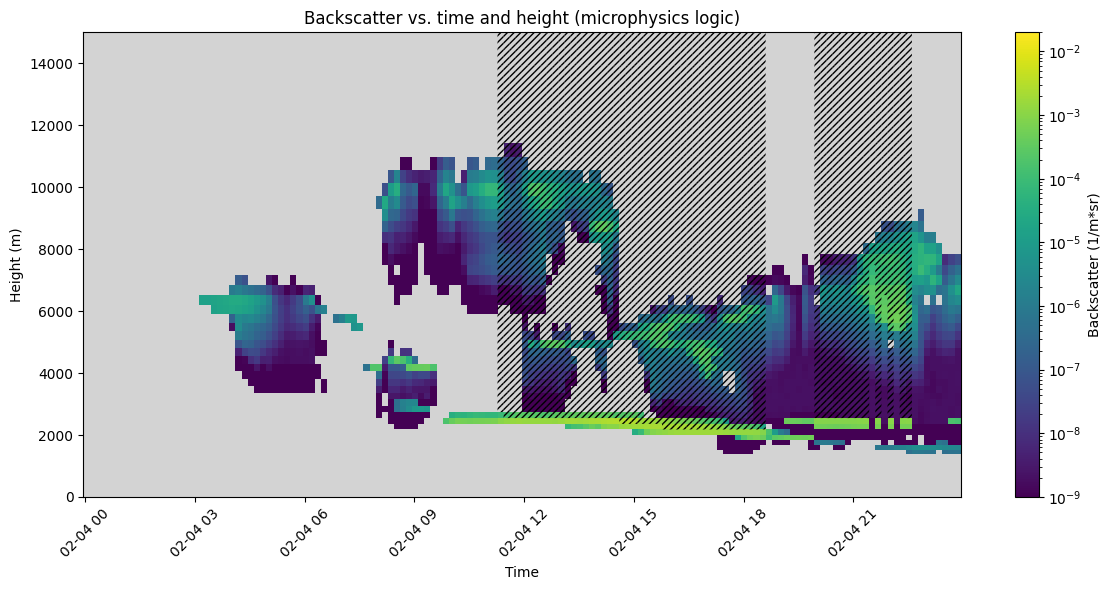

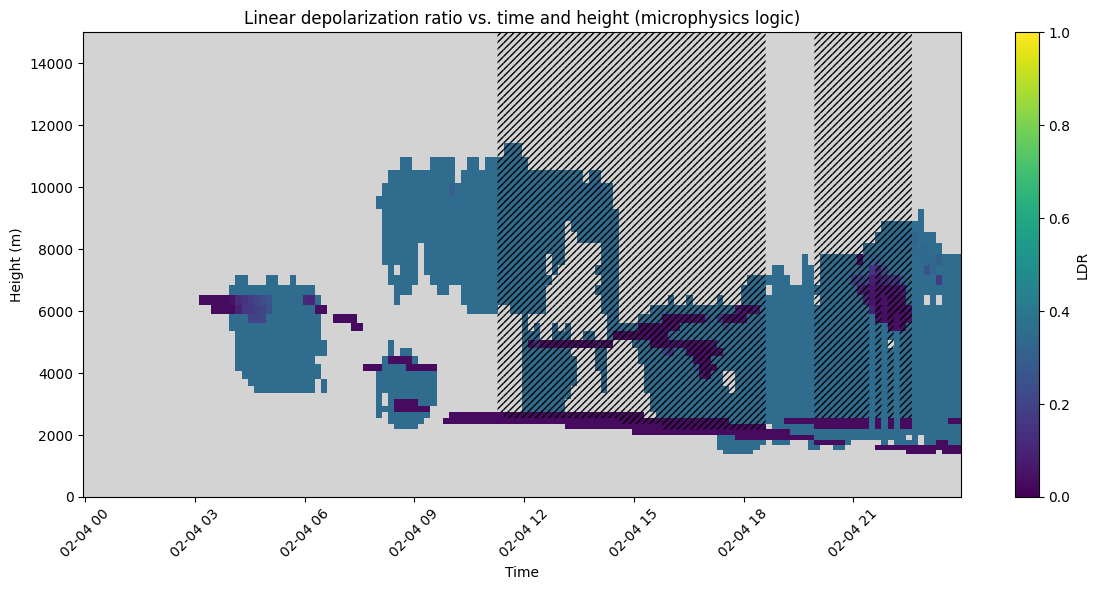

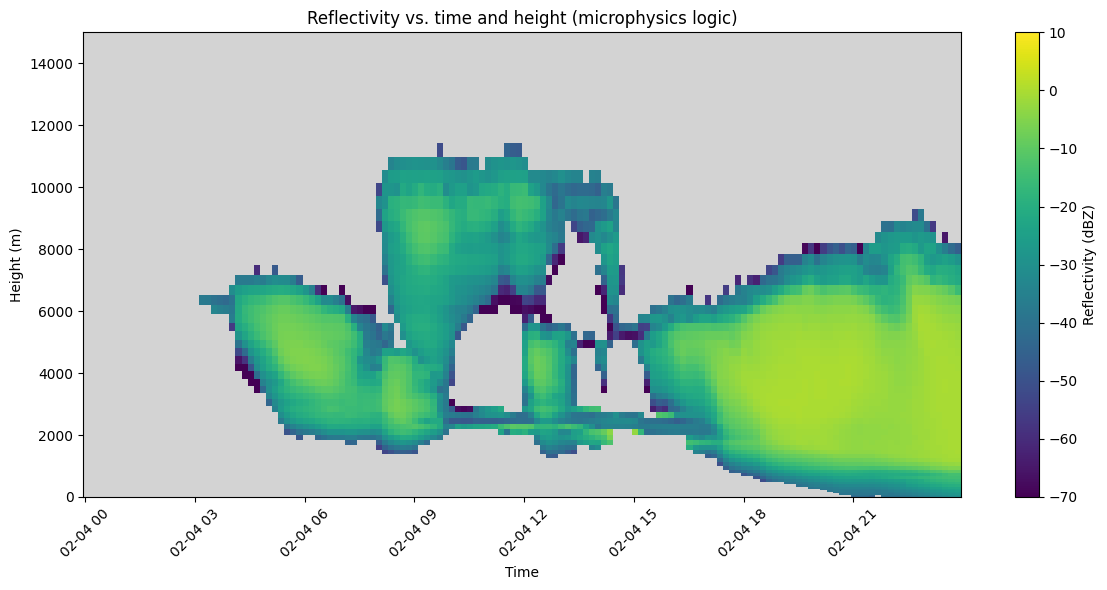

In [87]:
# Set the height limit for the plots
ylim_max = 15000

# Backscatter
# Create a meshgrid for time and height to be used for all lidar plots produced from the current file
time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MPL_microphysics_model.ds['time'], UM_reg_emc2_marcus_MPL_microphysics_model.ds['level_height'])
# Extract the desired variable
backscatter = UM_reg_emc2_marcus_MPL_microphysics_model.ds['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm=LogNorm(vmin=1e-9, vmax=2e-2))
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
plt.title('Backscatter vs. time and height (microphysics logic)')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# Mask areas where ext_mask != 2
ext_mask = UM_reg_emc2_marcus_MPL_microphysics_model.ds['ext_mask'].isel(subcolumn=0).drop('subcolumn')
masked_ext_mask = np.where(ext_mask == 2, ext_mask, np.nan)
# Overplot areas where ext_mask == 2 with black hatching
plt.pcolor(time_mesh, height_mesh, masked_ext_mask.T, hatch='/////', alpha=0.)
UM_reg_emc2_output_backscatter = plt.gcf()
# Save the plot
UM_reg_emc2_output_backscatter.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_backscatter_microphysics', dpi = 200)

# Depol
# Extract the desired variable
depol = UM_reg_emc2_marcus_MPL_microphysics_model.ds['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'viridis', shading = 'auto', vmin=0, vmax=1)
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'LDR')
plt.title('Linear depolarization ratio vs. time and height (microphysics logic)')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# Mask areas where ext_mask != 2
ext_mask = UM_reg_emc2_marcus_MPL_microphysics_model.ds['ext_mask'].isel(subcolumn=0).drop('subcolumn')
masked_ext_mask = np.where(ext_mask == 2, ext_mask, np.nan)
# Overplot areas where ext_mask == 2 with black hatching
plt.pcolor(time_mesh, height_mesh, masked_ext_mask.T, hatch='/////', alpha=0.)
UM_reg_emc2_output_depol = plt.gcf()
# Save the plot
UM_reg_emc2_output_depol.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_depol_microphysics', dpi = 200)

# Reflectivity
# Create a meshgrid for time and height to be used for all radar plots produced from the current file
time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_marcus_MWACR_microphysics_model.ds['time'], UM_reg_emc2_marcus_MWACR_microphysics_model.ds['level_height'])
# Extract the desired variable
reflectivity = UM_reg_emc2_marcus_MWACR_microphysics_model.ds['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto', vmin=-70, vmax=10)
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
plt.title('Reflectivity vs. time and height (microphysics logic)')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# # Mask areas where ext_mask != 1
# detect_mask = UM_reg_emc2_marcus_MWACR_microphysics_model.ds['detect_mask'].isel(subcolumn=0).drop('subcolumn')
# masked_detect_mask = np.where(detect_mask == 1, detect_mask, np.nan)
# # Overplot areas where ext_mask == 1 with black hatching
# plt.pcolor(time_mesh, height_mesh, masked_detect_mask.T, hatch='/////', alpha=0.)
UM_reg_emc2_output_reflectivity = plt.gcf()
# Save the plot
UM_reg_emc2_output_reflectivity.savefig('/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_test/UM_reg_emc2_output_test_reflectivity_microphysics', dpi = 200)

# Plotting - multiple files

In [16]:
# Load data

# Create the list of full filepaths to the daily files
# Set file parent folder
emc2_output_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/'
# List daily files in the parent folder
emc2_output_list = os.listdir(path = emc2_output_filepath)
# Create the list of daily filepaths
emc2_output_list = [os.path.join(emc2_output_filepath, file) for file in emc2_output_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
emc2_output_list = sorted(emc2_output_list, key = extract_date)
emc2_output_list_MPL_radiation = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MPL_radiation' in path]
emc2_output_list_MWACR_radiation = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MWACR_radiation' in path]
emc2_output_list_MPL_microphysics = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MPL_microphysics' in path]
emc2_output_list_MWACR_microphysics = [path for path in emc2_output_list if 'um_reg_emc2_marcus_MWACR_microphysics' in path]
# emc2_output_list_MPL_radiation
# emc2_output_list_MWACR_radiation
# emc2_output_list_MPL_microphysics
# emc2_output_list_MWACR_microphysics

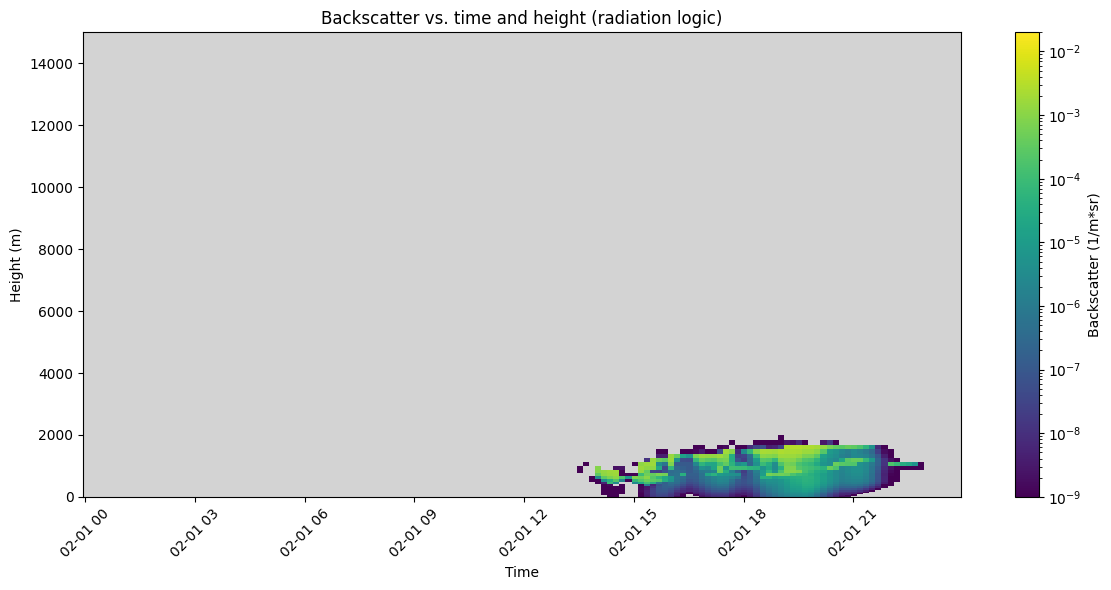

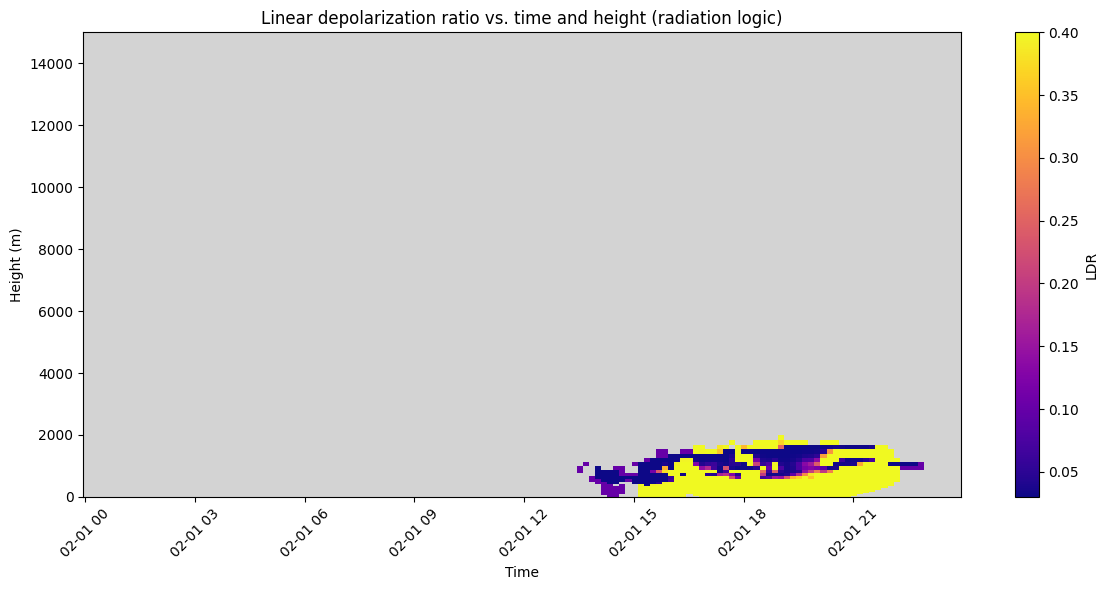

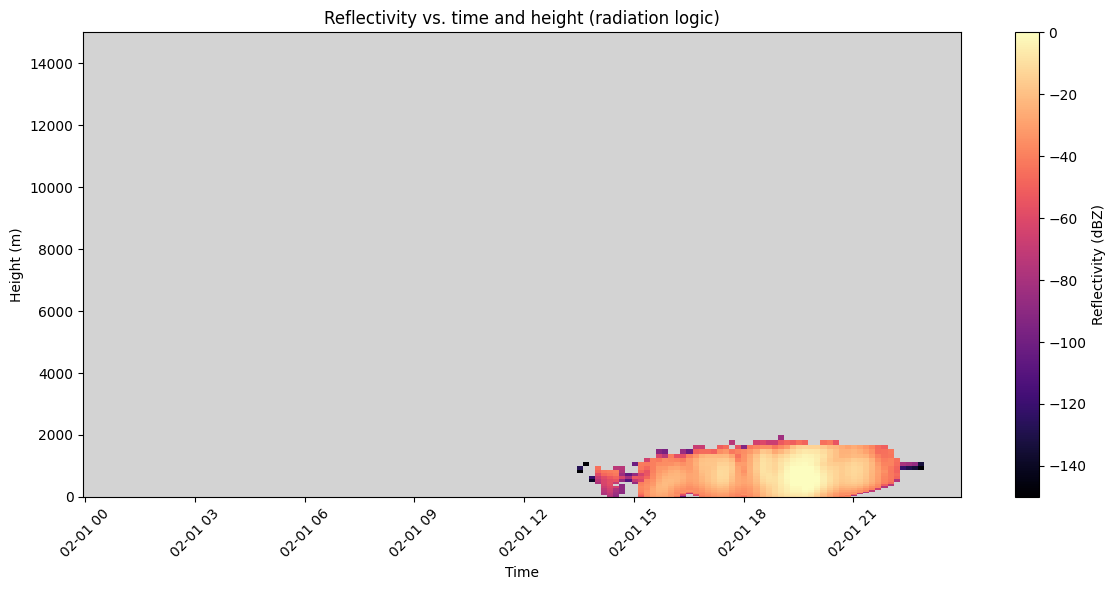

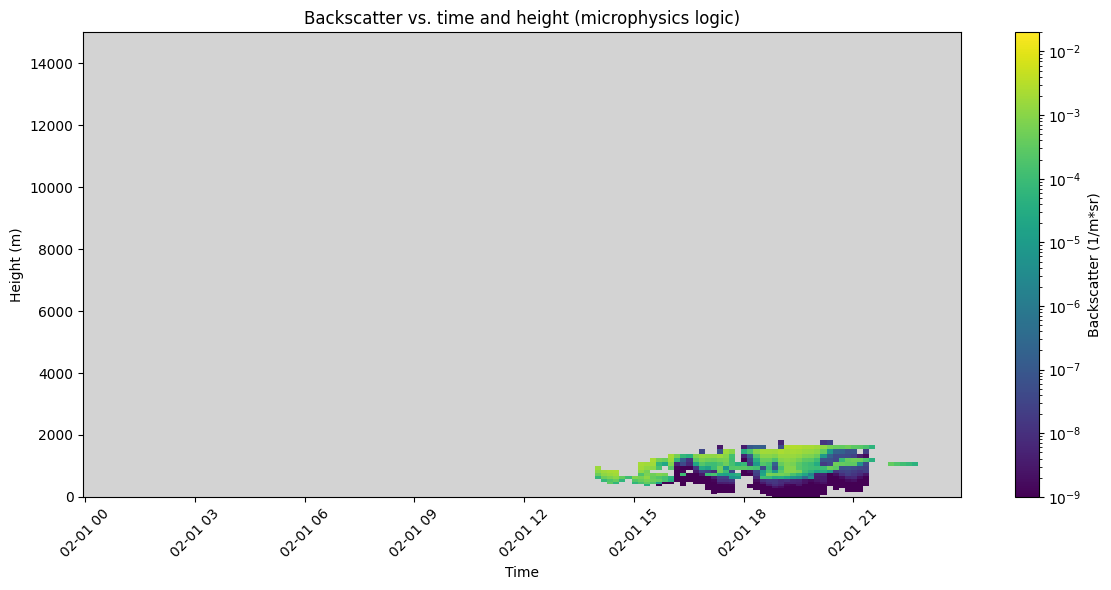

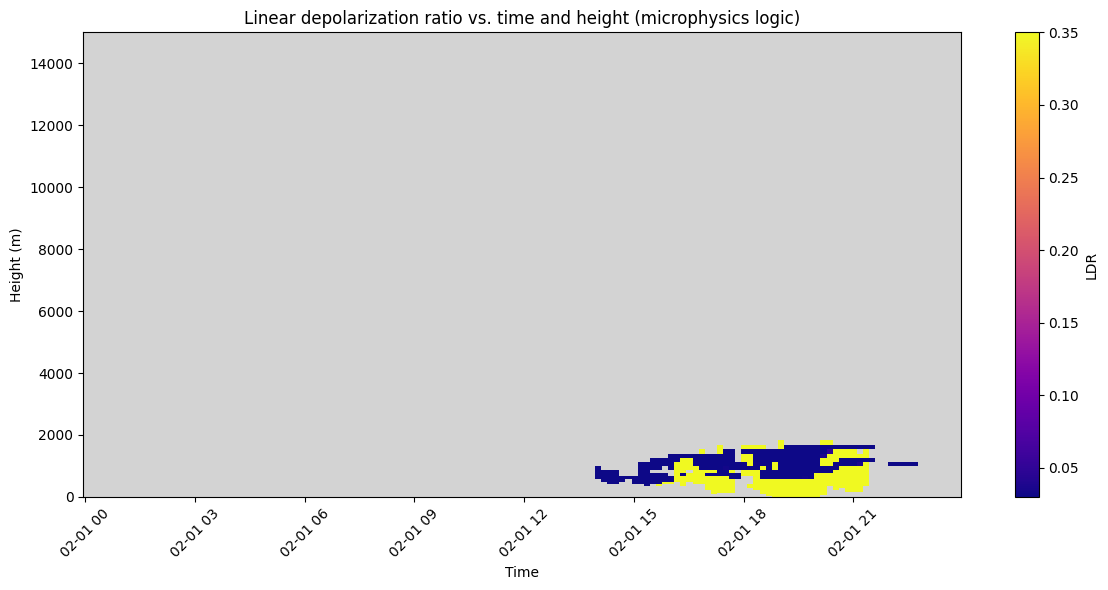

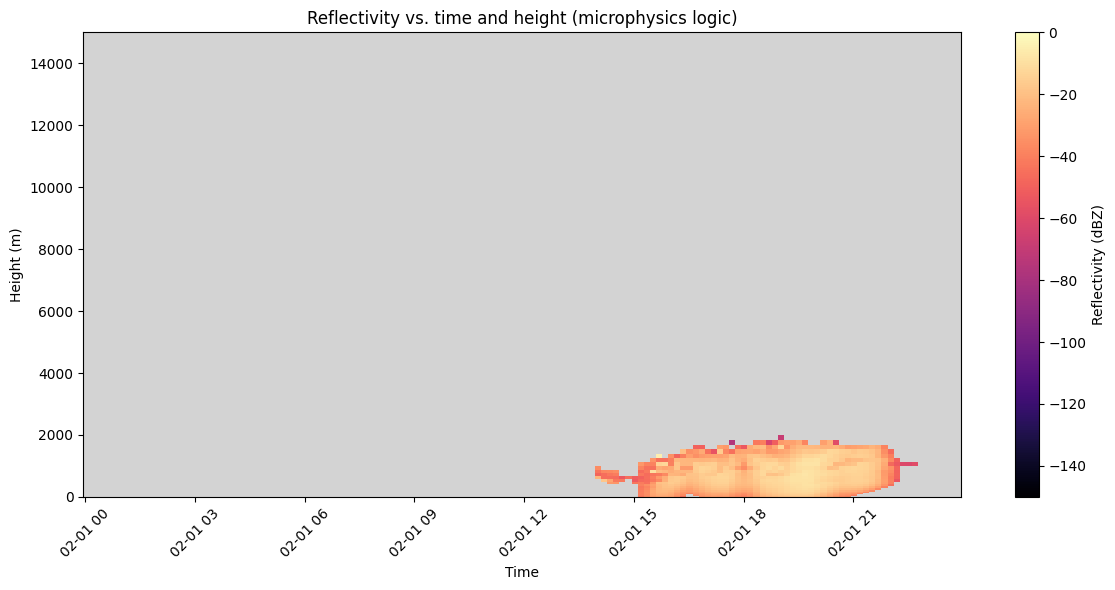

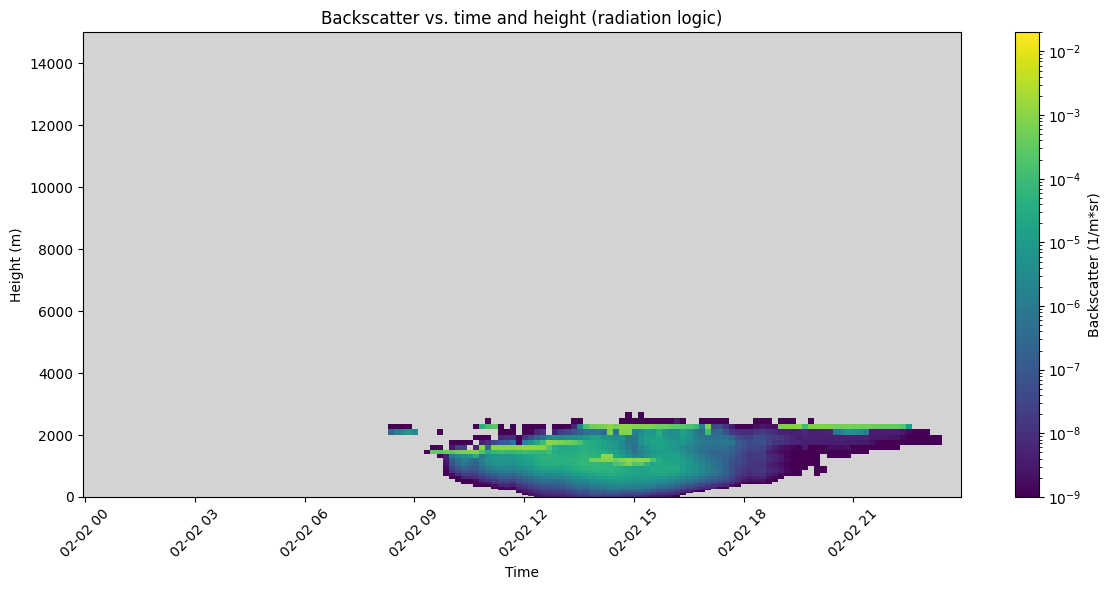

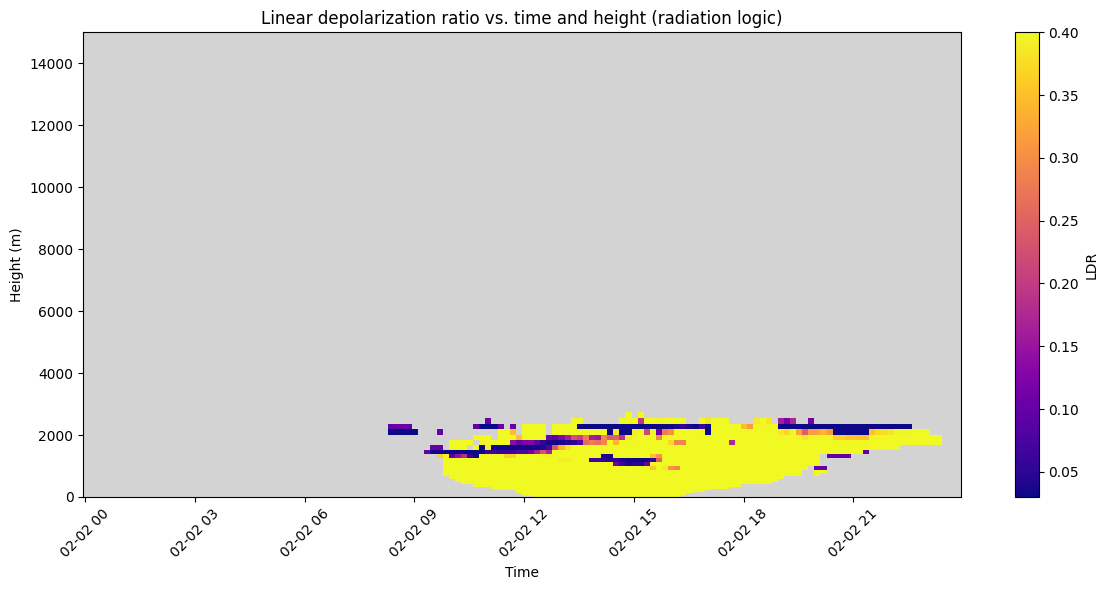

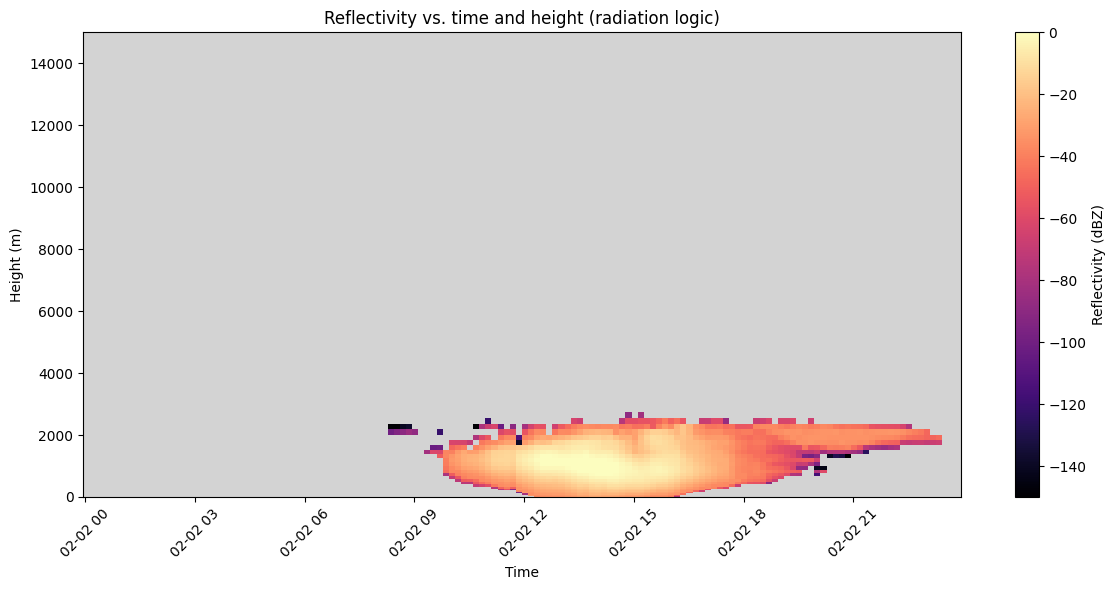

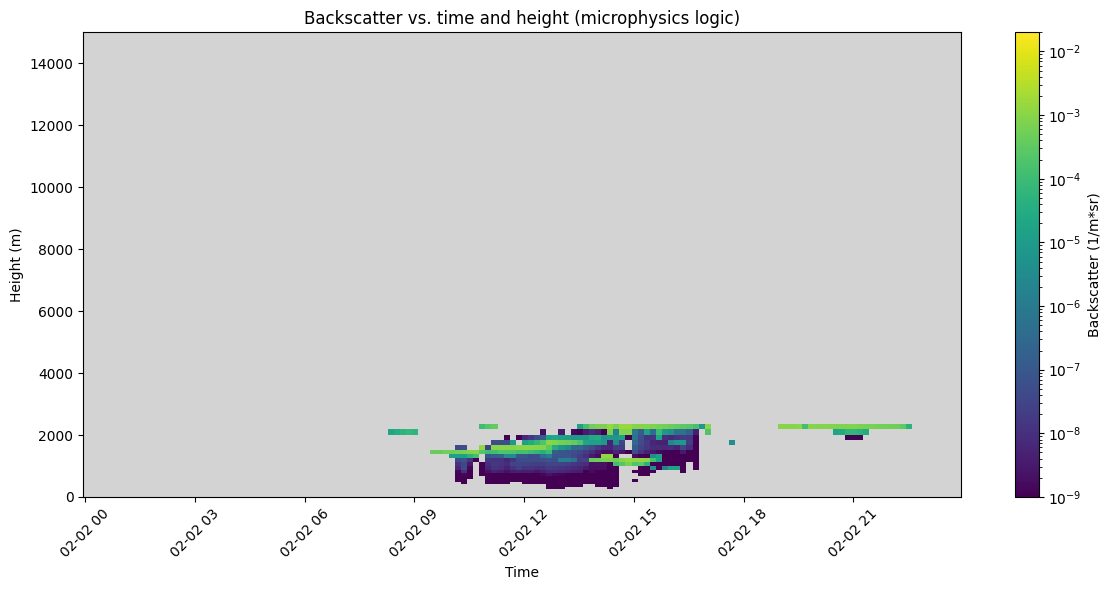

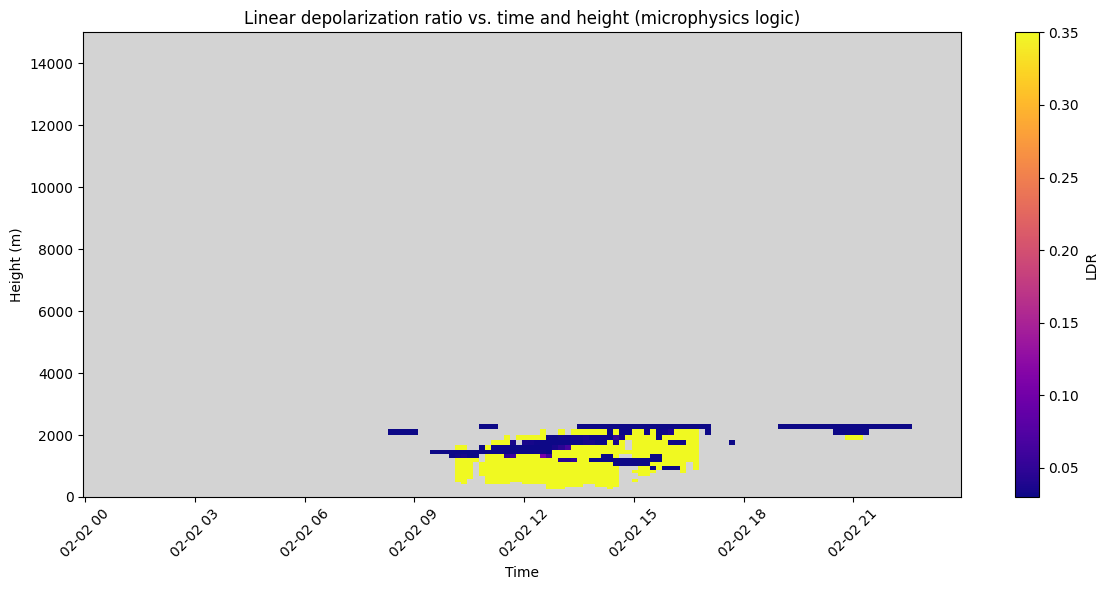

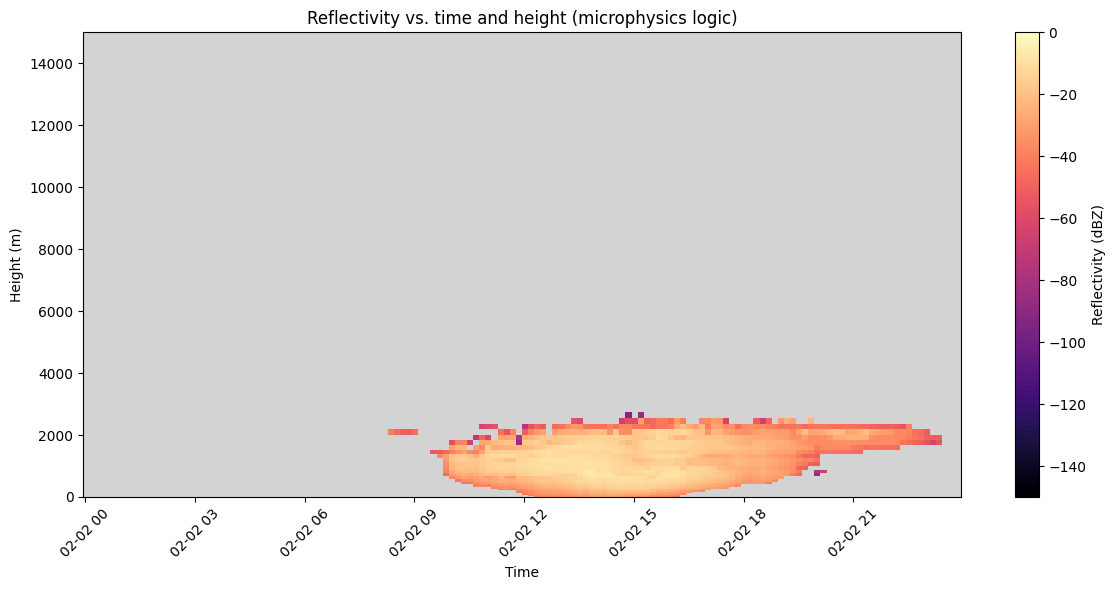

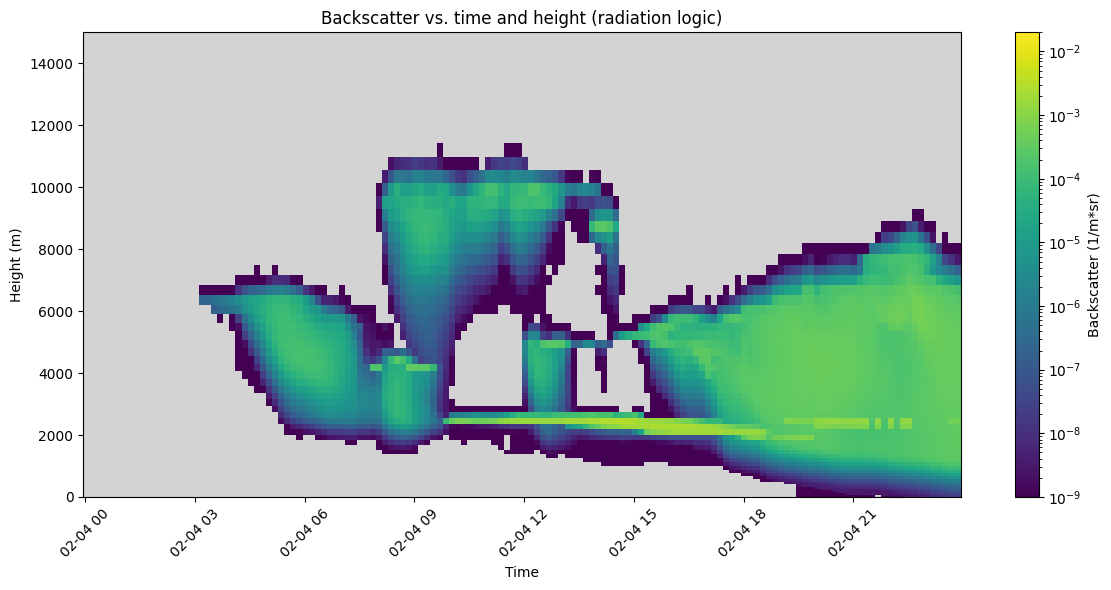

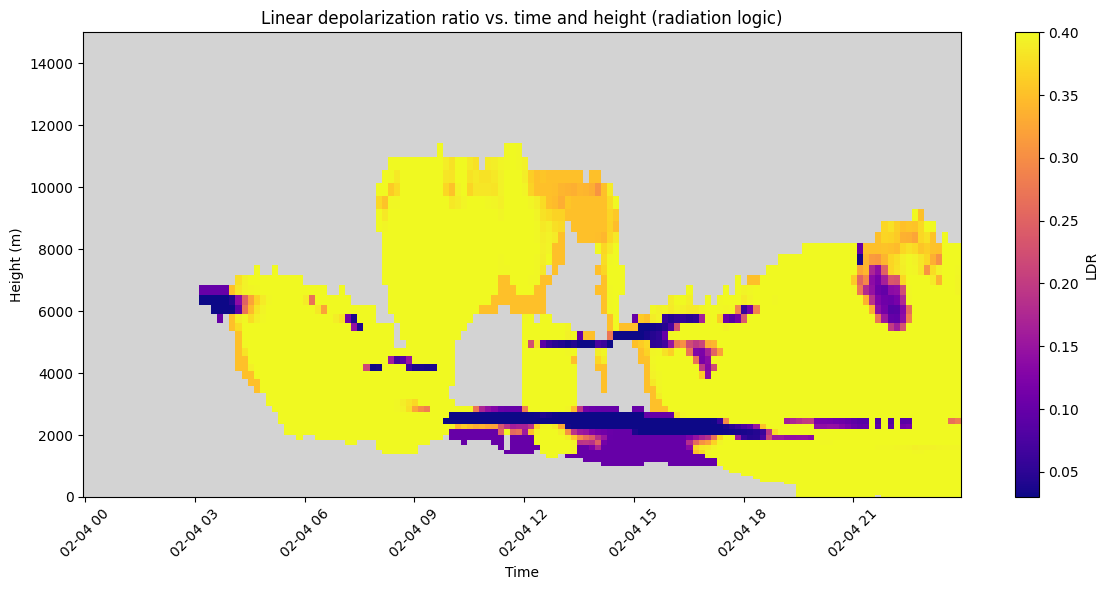

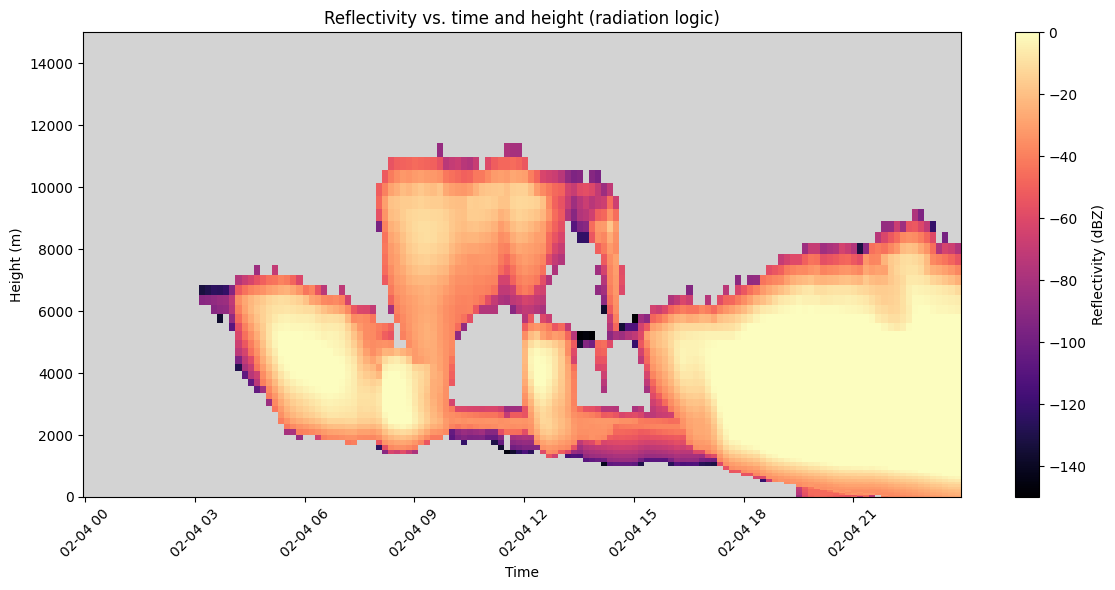

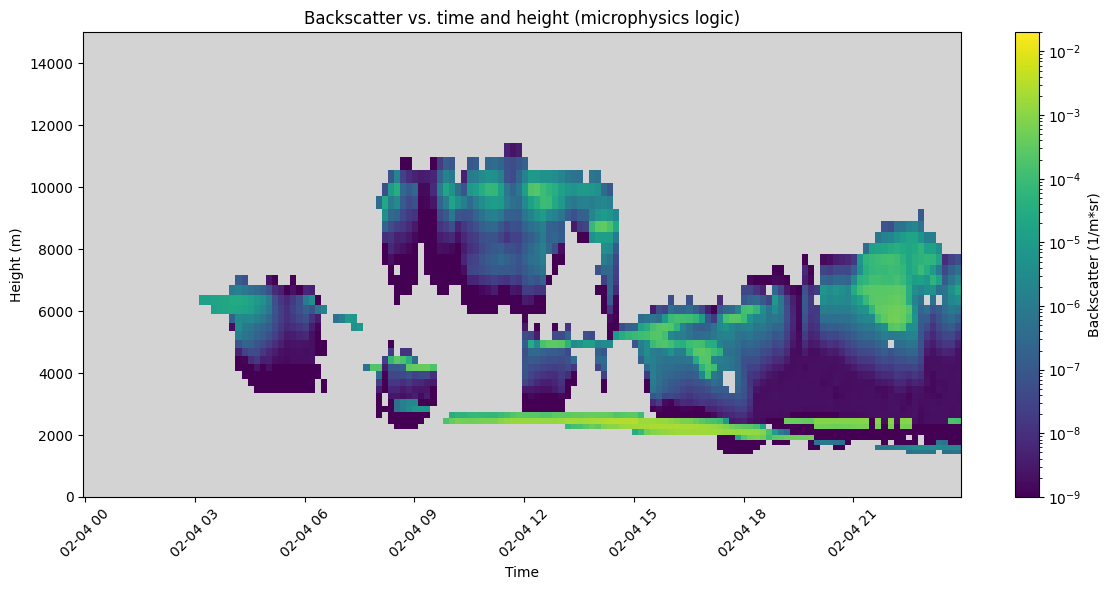

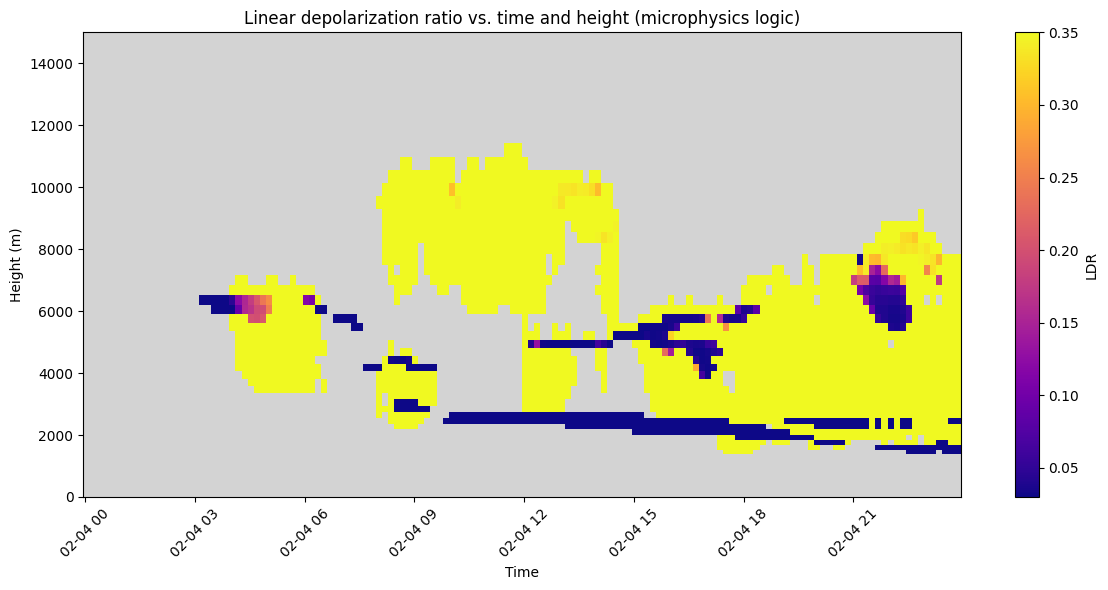

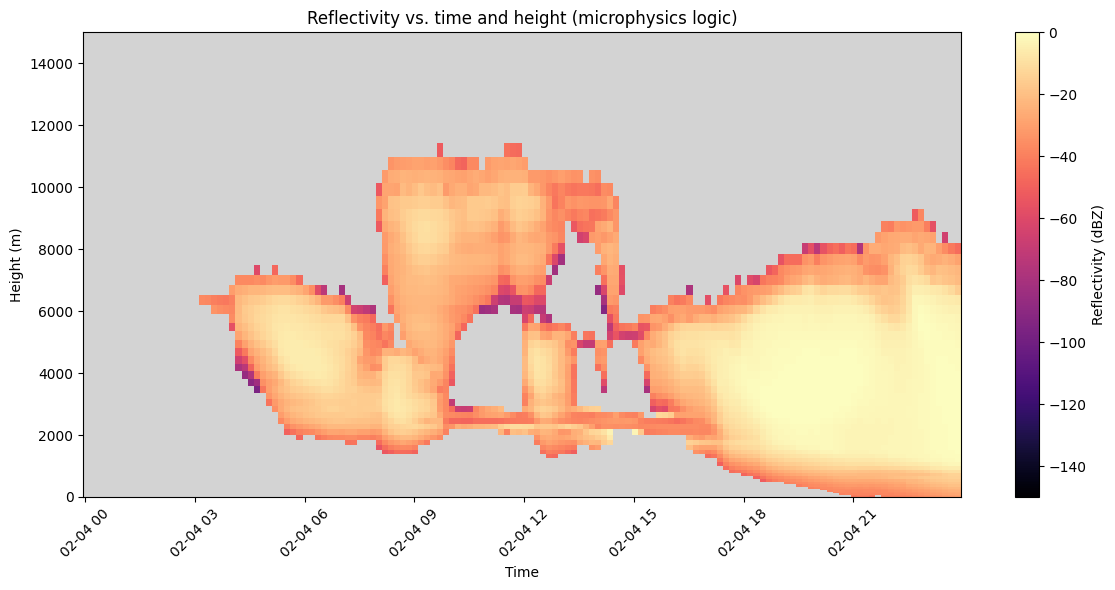

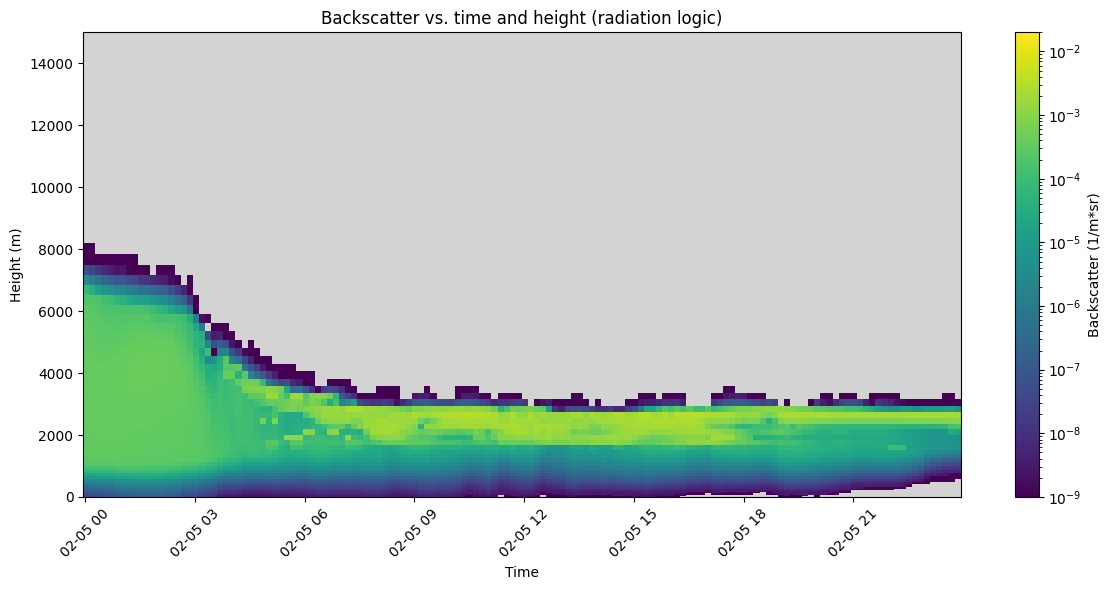

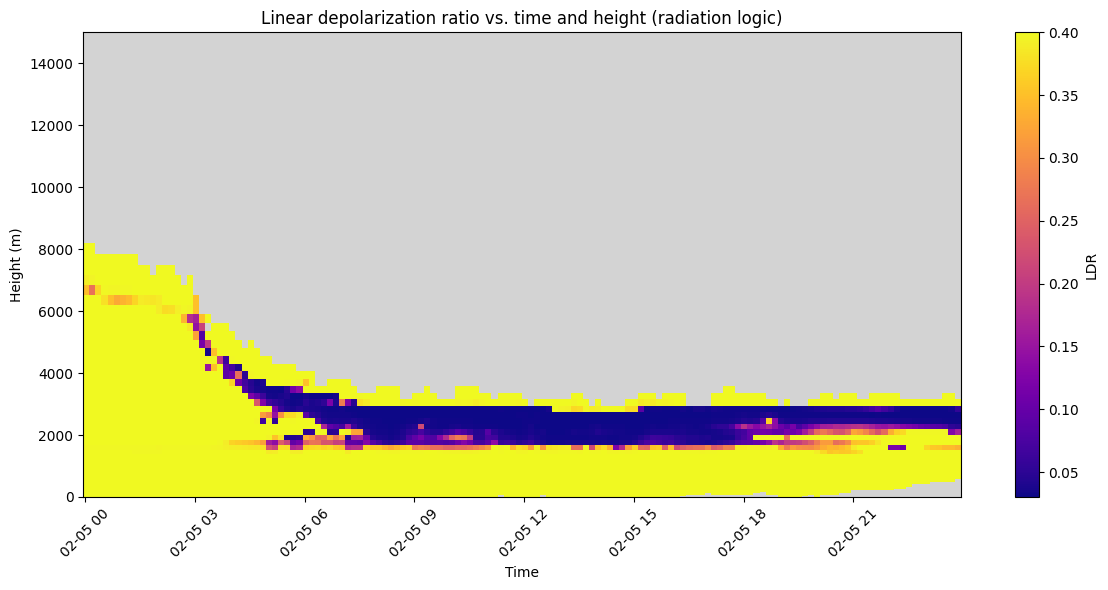

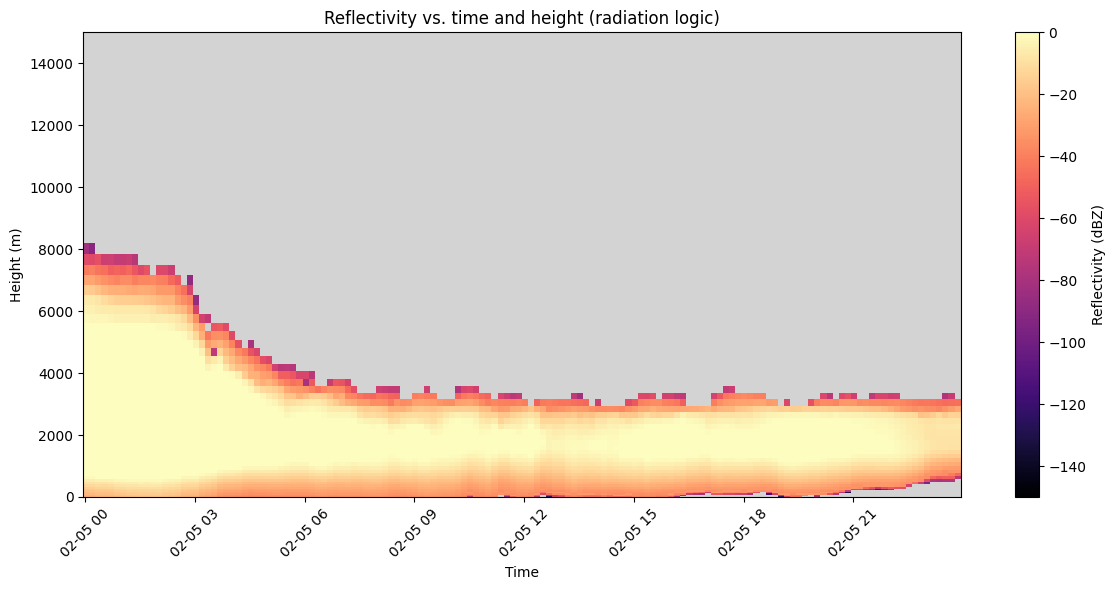

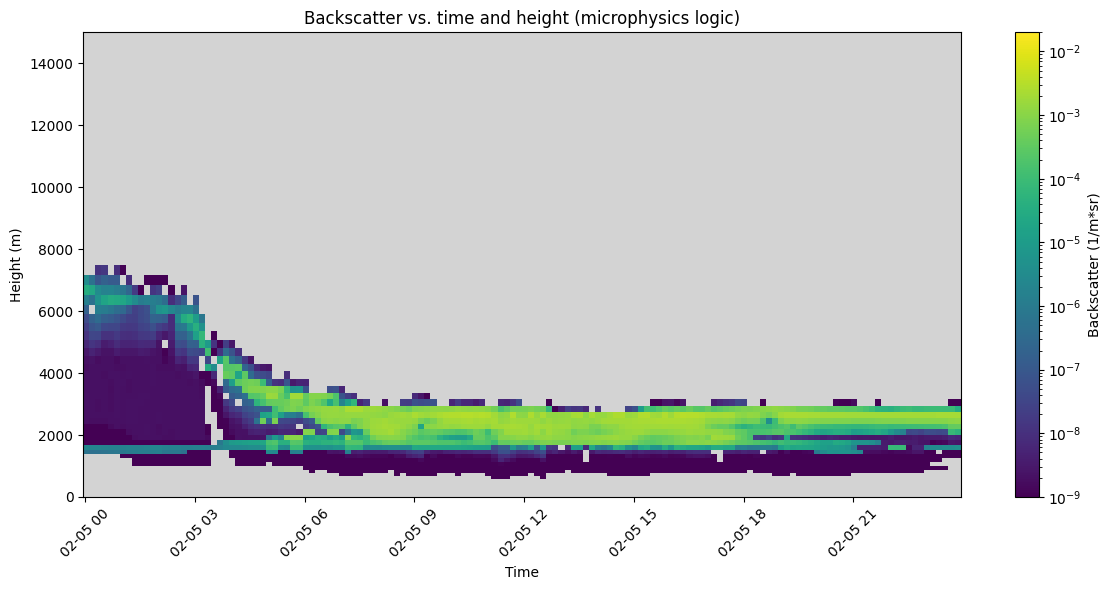

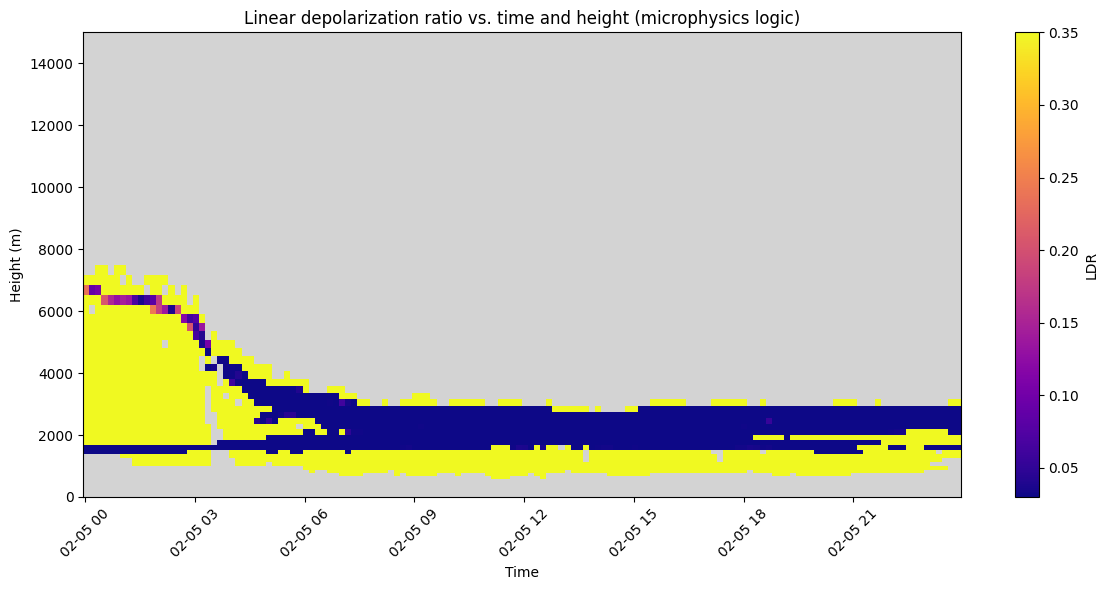

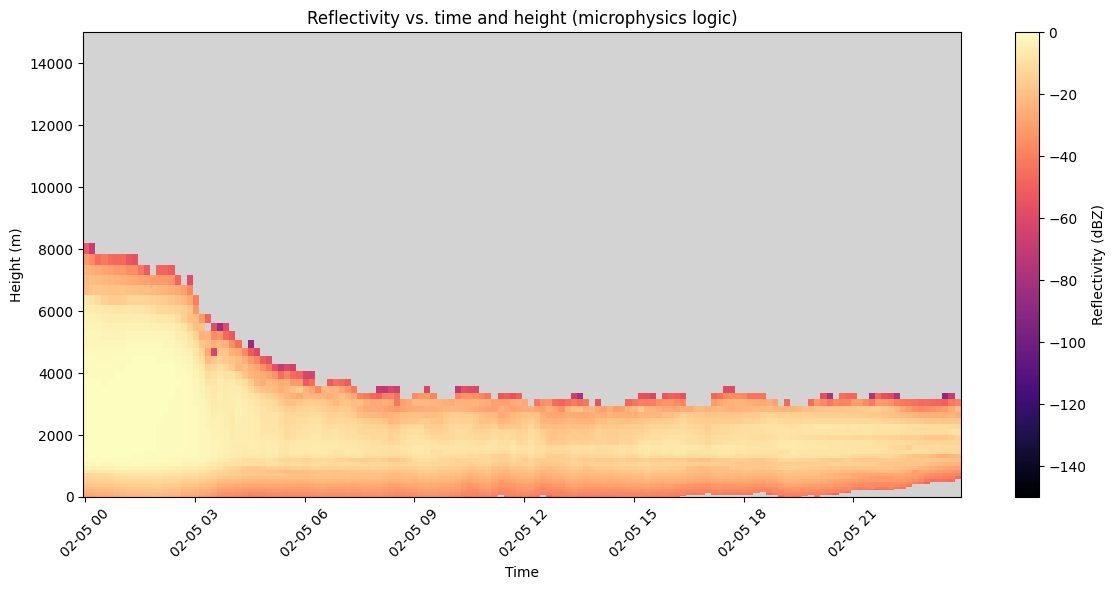

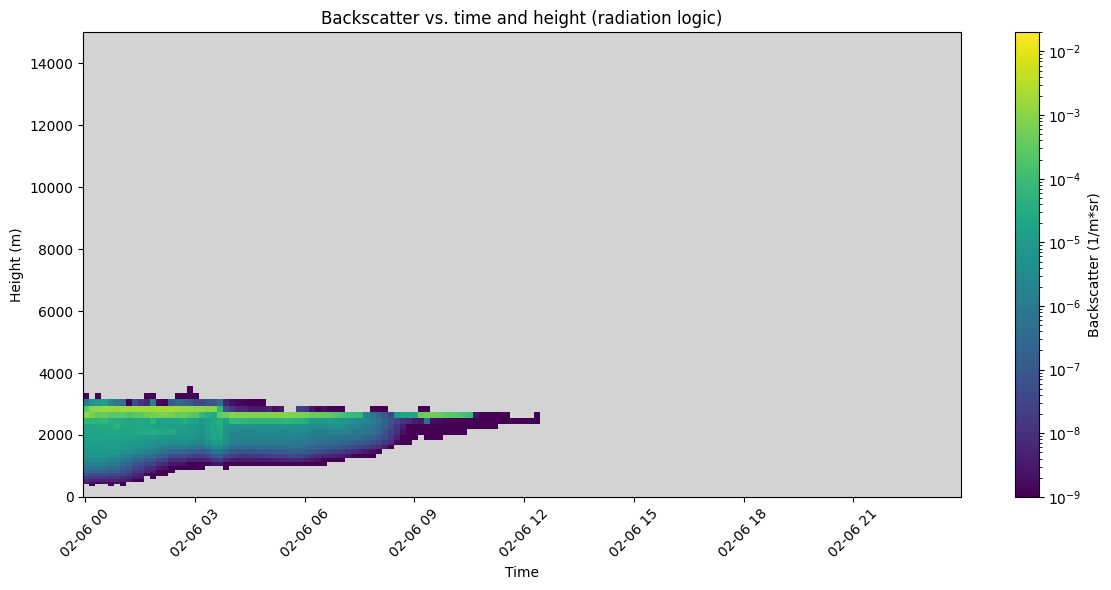

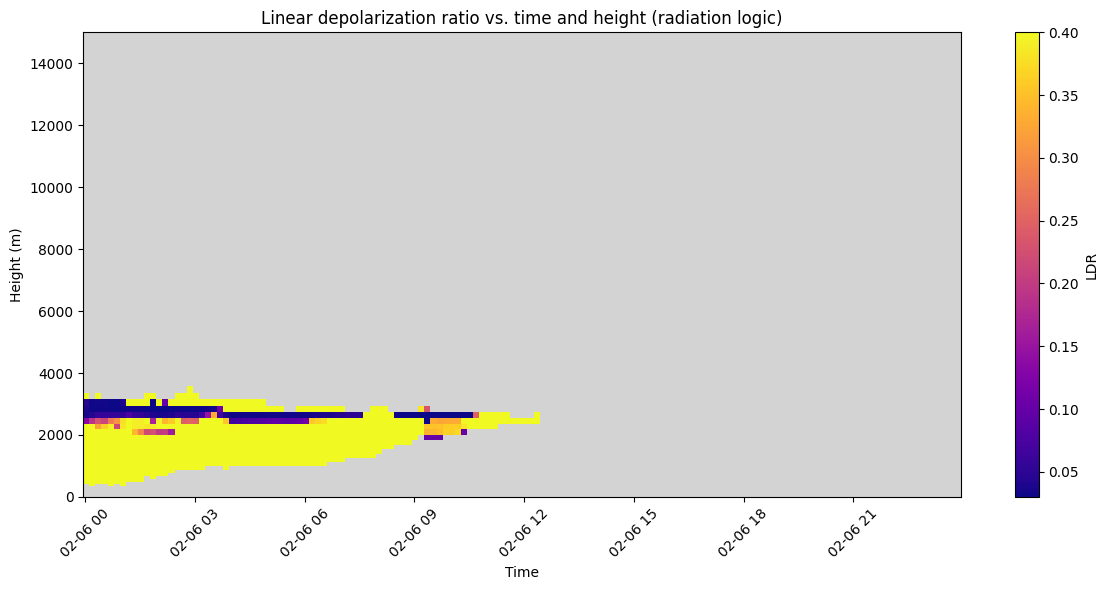

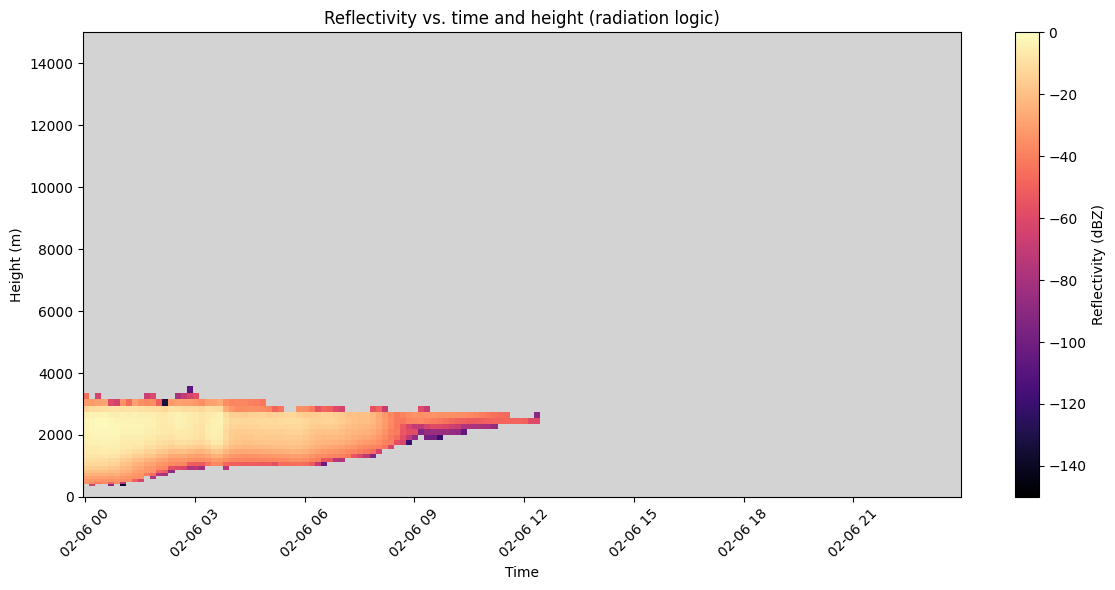

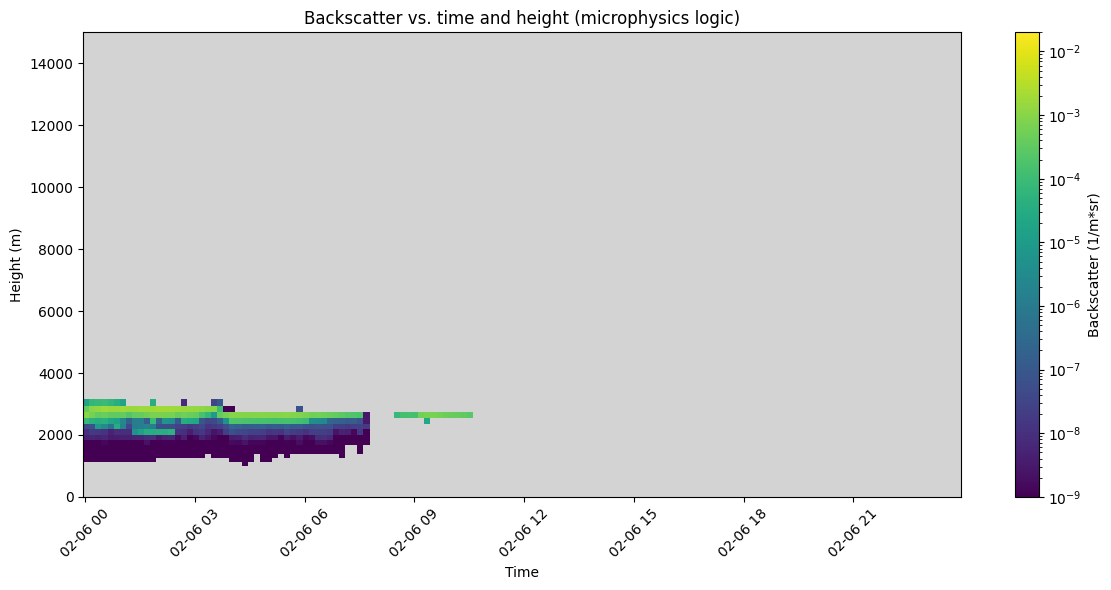

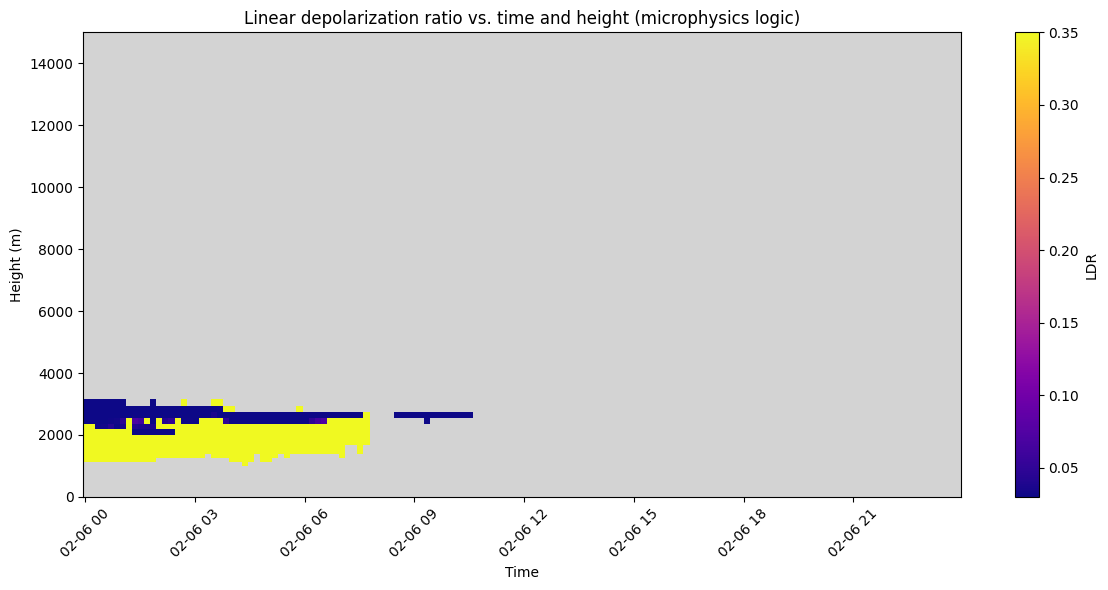

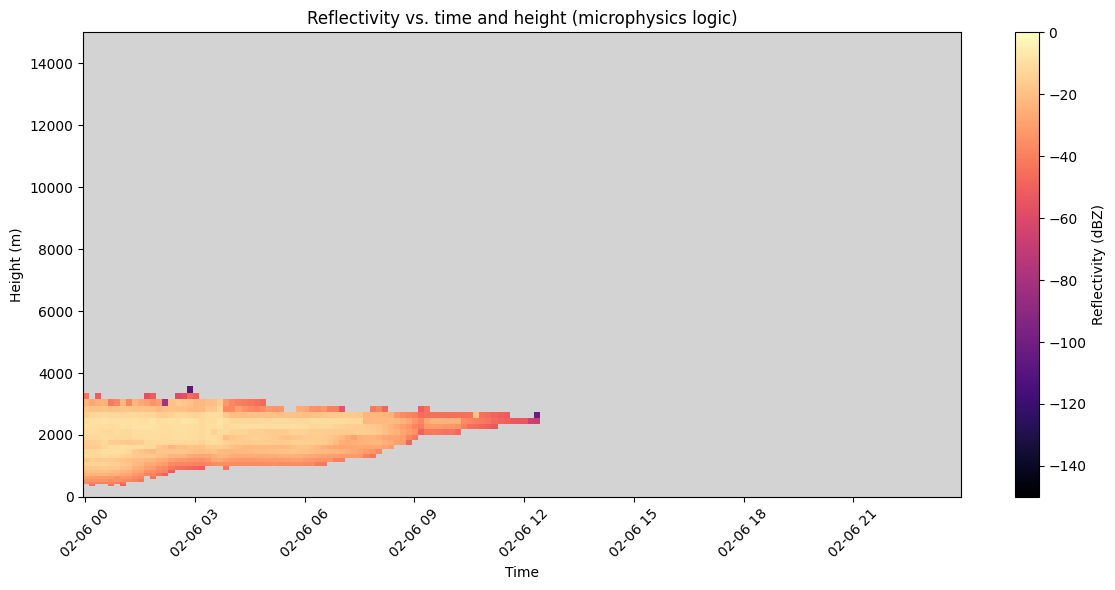

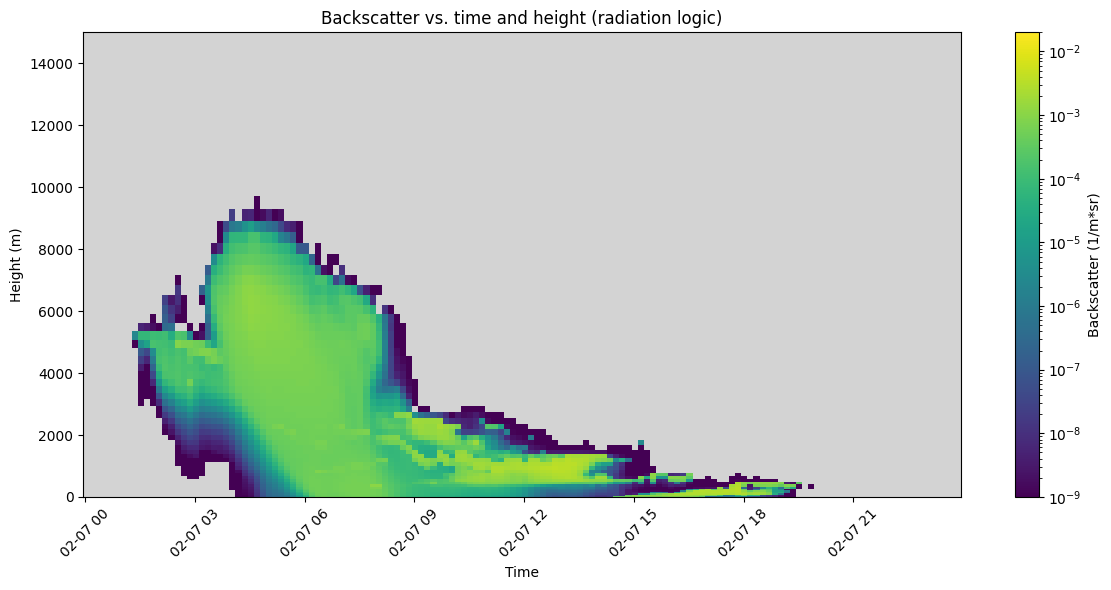

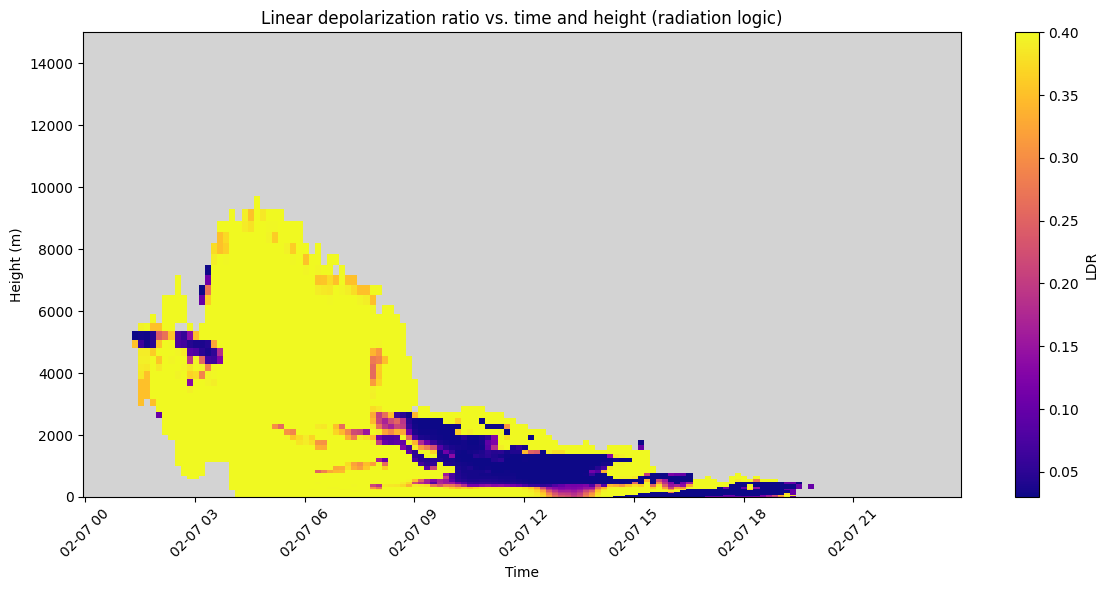

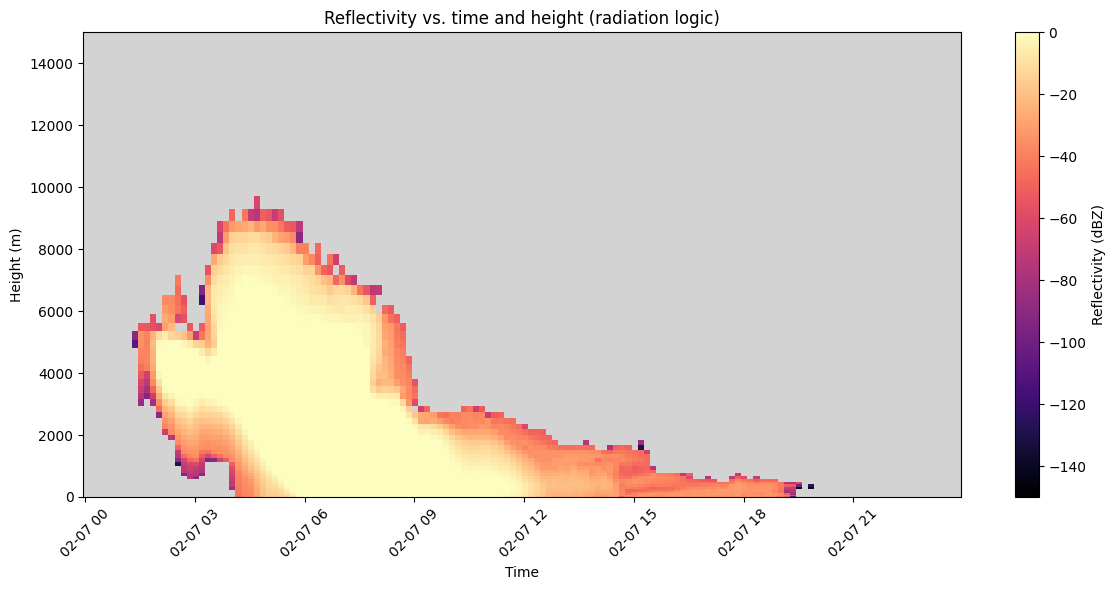

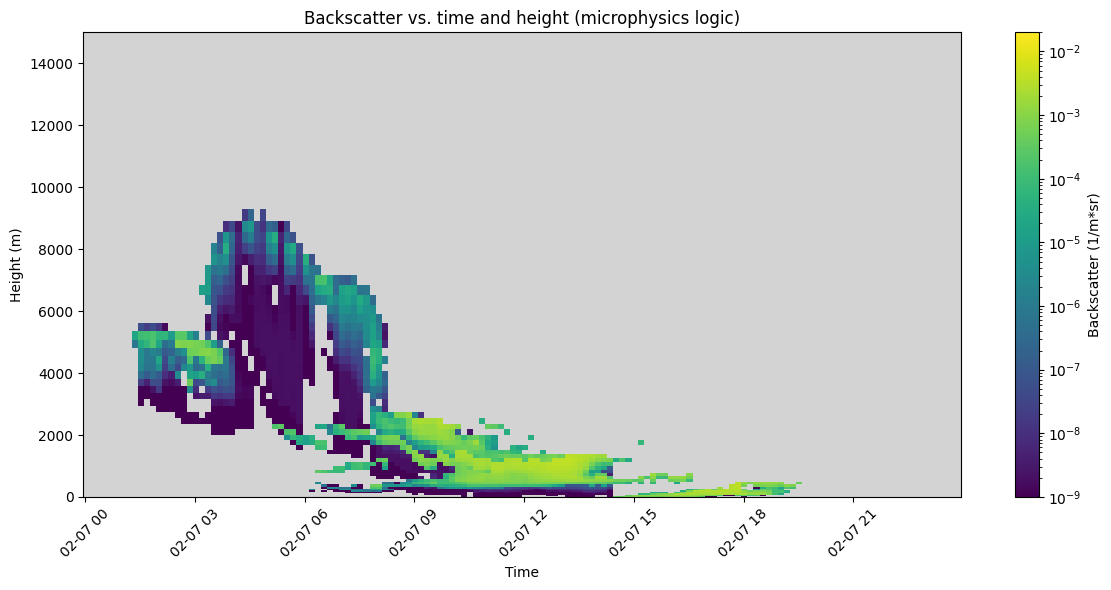

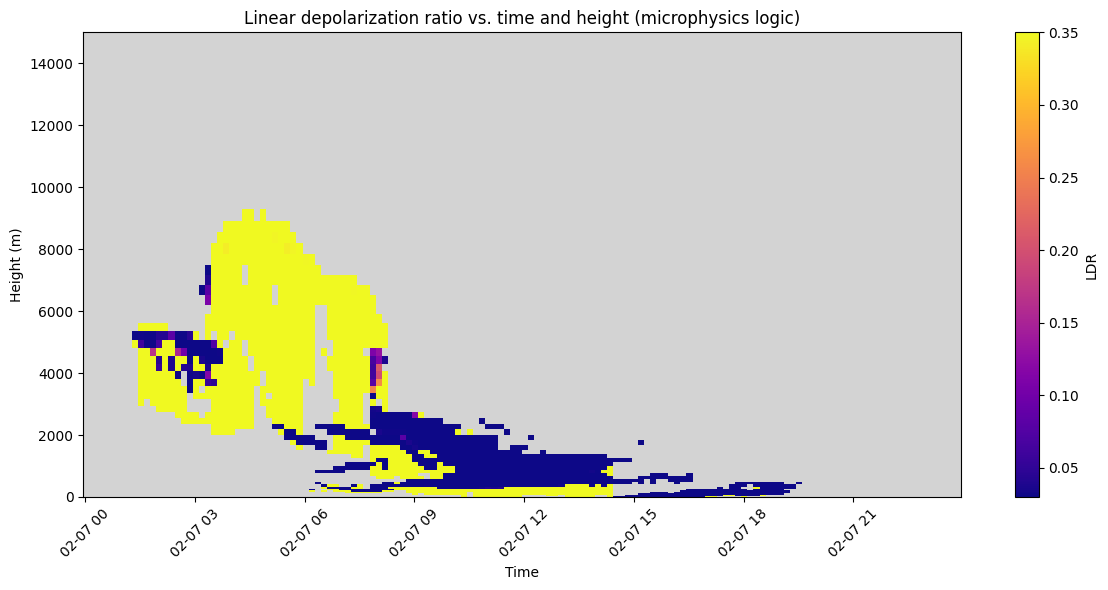

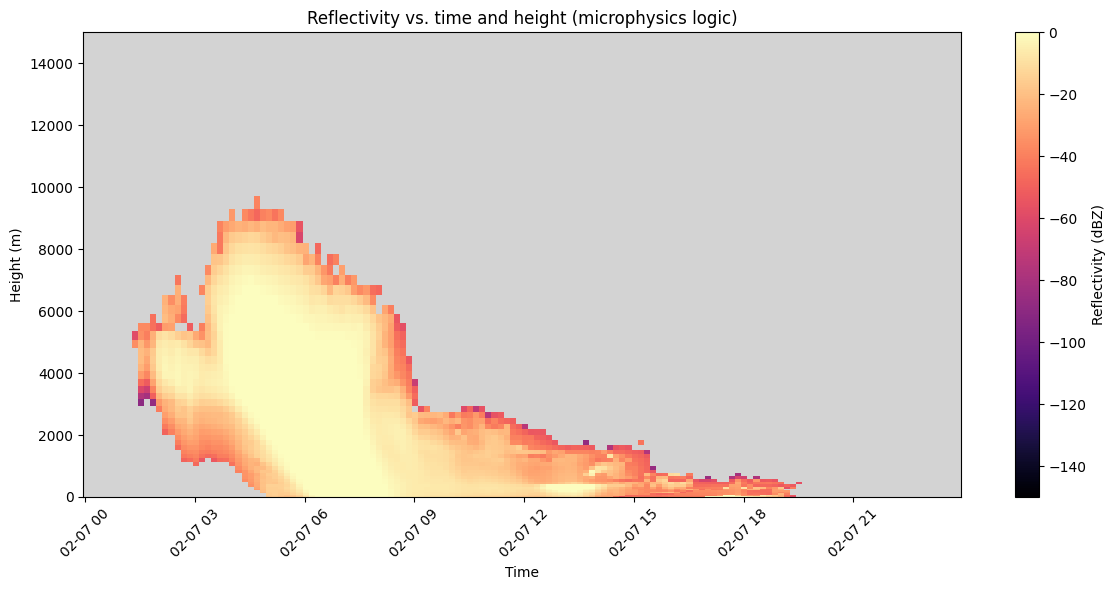

In [25]:
# Set the height limit for the plots
ylim_max = 15000

# Iterate across all files to create and save images of backscatter, depolarization, and reflectivity
for i in range(0, 7):
    # # Skip day 3
    # if i == 2:
    #     continue
    # Open files and extract current date
    file_MPL_radiation = emc2_output_list_MPL_radiation[i]
    file_MWACR_radiation = emc2_output_list_MWACR_radiation[i]
    file_MPL_microphysics = emc2_output_list_MPL_microphysics[i]
    file_MWACR_microphysics = emc2_output_list_MWACR_microphysics[i]
    UM_reg_emc2_output_MPL_radiation = xr.open_dataset(file_MPL_radiation)
    UM_reg_emc2_output_MWACR_radiation = xr.open_dataset(file_MWACR_radiation)
    UM_reg_emc2_output_MPL_microphysics = xr.open_dataset(file_MPL_microphysics)
    UM_reg_emc2_output_MWACR_microphysics = xr.open_dataset(file_MWACR_microphysics)
    current_date_str = file_MPL_radiation.split('_')[-1].split('.')[0]

    # Radiation logic
    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_output_MPL_radiation['time'], UM_reg_emc2_output_MPL_radiation['level_height'])
    # Backscatter
    # Extract the desired variable
    backscatter = UM_reg_emc2_output_MPL_radiation['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm=LogNorm(vmin=1e-9, vmax=2e-2))
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
    plt.title('Backscatter vs. time and height (radiation logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_backscatter = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_backscatter_radiation_{current_date_str}', dpi = 200)
    # Depol
    # Extract the desired variable
    depol = UM_reg_emc2_output_MPL_radiation['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'LDR')
    plt.title('Linear depolarization ratio vs. time and height (radiation logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_depol = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_depol.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_depol_radiation_{current_date_str}', dpi = 200)
    # Reflectivity
    # Create a meshgrid for time and height to be used for all radar plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_output_MWACR_radiation['time'], UM_reg_emc2_output_MWACR_radiation['level_height'])
    # Extract the desired variable
    reflectivity = UM_reg_emc2_output_MWACR_radiation['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'magma', shading = 'auto', vmin=-150, vmax=0)
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
    plt.title('Reflectivity vs. time and height (radiation logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_reflectivity = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_reflectivity.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_reflectivity_radiation_{current_date_str}', dpi = 200)

    # Microphysics logic
    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_output_MPL_microphysics['time'], UM_reg_emc2_output_MPL_microphysics['level_height'])
    # Backscatter
    # Extract the desired variable
    backscatter = UM_reg_emc2_output_MPL_microphysics['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm=LogNorm(vmin=1e-9, vmax=2e-2))
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
    plt.title('Backscatter vs. time and height (microphysics logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_backscatter = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_backscatter_microphysics_{current_date_str}', dpi = 200)
    # Depol
    # Extract the desired variable
    depol = UM_reg_emc2_output_MPL_microphysics['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'LDR')
    plt.title('Linear depolarization ratio vs. time and height (microphysics logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_depol = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_depol.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_depol_microphysics_{current_date_str}', dpi = 200)
    # Reflectivity
    # Create a meshgrid for time and height to be used for all radar plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(UM_reg_emc2_output_MWACR_microphysics['time'], UM_reg_emc2_output_MWACR_microphysics['level_height'])
    # Extract the desired variable
    reflectivity = UM_reg_emc2_output_MWACR_microphysics['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'magma', shading = 'auto', vmin=-150, vmax=0)
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
    plt.title('Reflectivity vs. time and height (microphysics logic)')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    UM_reg_emc2_output_reflectivity = plt.gcf()
    # Save the plot
    UM_reg_emc2_output_reflectivity.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_emc2_output/UM_reg_emc2_output_reflectivity_microphysics_{current_date_str}', dpi = 200)